In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-a-more-diverse-dataset/train.csv


In [3]:
import pandas as pd

df = pd.read_csv('/kaggle/input/sms-spam-collection-a-more-diverse-dataset/train.csv')

print(df.head())

                                                 sms  label
0  Go until jurong point, crazy.. Available only ...      0
1                    Ok lar... Joking wif u oni...\n      0
2  Free entry in 2 a wkly comp to win FA Cup fina...      1
3  U dun say so early hor... U c already then say...      0
4  Nah I don't think he goes to usf, he lives aro...      0


In [4]:
!pip install contractions

In [5]:
df

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1
5570,Will ü b going to esplanade fr home?\n,0
5571,"Pity, * was in mood for that. So...any other s...",0
5572,The guy did some bitching but I acted like i'd...,0


In [6]:
"""
import contractions
import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()  # enables progress_apply for a progress bar

# Apply contraction expansion to each row
df['expanded_sms'] = df['sms'].progress_apply(lambda x: contractions.fix(str(x)))"""

"\nimport contractions\nimport pandas as pd\nfrom tqdm.notebook import tqdm\n\ntqdm.pandas()  # enables progress_apply for a progress bar\n\n# Apply contraction expansion to each row\ndf['expanded_sms'] = df['sms'].progress_apply(lambda x: contractions.fix(str(x)))"

In [7]:
!pip install num2words

In [8]:
import re
from num2words import num2words
import contractions
from tqdm.notebook import tqdm

tqdm.pandas()

ordinal_pattern = re.compile(r'\b(\d+)(st|nd|rd|th)\b', re.IGNORECASE)

def expand_ordinals(text):
    text = str(text)
    return ordinal_pattern.sub(
        lambda m: num2words(int(m.group(1)), to='ordinal'),
        text
    )

df['expanded_sms'] = (
    df['sms']
    .progress_apply(expand_ordinals)
    .progress_apply(contractions.fix)
)

  0%|          | 0/5574 [00:00<?, ?it/s]

  0%|          | 0/5574 [00:00<?, ?it/s]

In [9]:
"""
import spacy

def extract_entities(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    entities = [(ent.text , ent.label_) for ent in doc.ents]
    return entities

entities = df['sentences'].progress_apply(extract_entities)
"""

'\nimport spacy\n\ndef extract_entities(text):\n    nlp = spacy.load("en_core_web_sm")\n    doc = nlp(text)\n    entities = [(ent.text , ent.label_) for ent in doc.ents]\n    return entities\n\nentities = df[\'sentences\'].progress_apply(extract_entities)\n'

In [10]:
df

,sms,label,expanded_sms
0,"Go until jurong point, crazy.. Available only ...",0,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...\n,0,Ok lar... Joking wif you oni...\n
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,U dun say so early hor... U c already then say...,0,YOU dun say so early hor... YOU c already then...
4,"Nah I don't think he goes to usf, he lives aro...",0,"Nah I do not think he goes to usf, he lives ar..."
...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,This is the second time we have tried 2 contac...
5570,Will ü b going to esplanade fr home?\n,0,Will ü b going to esplanade fr home?\n
5571,"Pity, * was in mood for that. So...any other s...",0,"Pity, * was in mood for that. So...any other s..."
5572,The guy did some bitching but I acted like i'd...,0,The guy did some bitching but I acted like i w...


In [11]:
import re
import string
import pandas as pd
from tqdm import tqdm
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer
import nltk
import contractions

tqdm.pandas()

def clean_text(text, spell_correct=False, remove_stopwords=True):

    if not isinstance(text, str):
        return ""

    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\.\S+|https\S+', '', text)

    # 3. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # 3. REMOVE datetime FIRST ✅
    text = re.sub(
        r'on\s+\w+,\s+\d{4}-\d{2}-\d{2}\s+at\s+\d{1,2}:\d{2}',
        '',
        text,
        flags=re.IGNORECASE
    )

    # 4. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # 5. Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # 6. Remove hashtags (#hashtag)
    text = re.sub(r'#\w+', '', text)

    # 7. Remove repeated characters (heeeello -> helo)
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # 8. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 9. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 10. Remove extra whitespace
    text = ' '.join(text.split())

    # 11. Tokenize
    tokens = text.split()

    # 12. Remove stopwords (optional)
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        tokens = [w for w in tokens if w not in stop_words and len(w) >= 2]
    else:
        # Just filter short words
        tokens = [w for w in tokens if len(w) >= 2]
    """
    # 13. Spell correction (optional and SLOW)
    if spell_correct:
        tokens = [str(TextBlob(w).correct()) for w in tokens]
    """

    # Return cleaned tokens as string
    return ' '.join(tokens)


# Step 1: Clean the text
print("=== Step 1: Cleaning Text ===")
df['cleaned_sms'] = df['expanded_sms'].progress_apply(
    lambda x: clean_text(x, spell_correct=False, remove_stopwords=True)
)

print(f"Cleaning completed. Sample:\n{df['expanded_sms'].head(3)}")

=== Step 1: Cleaning Text ===


100%|██████████| 5574/5574 [00:00<00:00, 6288.57it/s]

Cleaning completed. Sample:
0    Go until jurong point, crazy.. Available only ...
1                    Ok lar... Joking wif you oni...\n
2    Free entry in 2 a wkly comp to win FA Cup fina...
Name: expanded_sms, dtype: object


In [12]:
df

,sms,label,expanded_sms,cleaned_sms
0,"Go until jurong point, crazy.. Available only ...",0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...
1,Ok lar... Joking wif u oni...\n,0,Ok lar... Joking wif you oni...\n,ok lar joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts twe...
3,U dun say so early hor... U c already then say...,0,YOU dun say so early hor... YOU c already then...,dun say early hor already say
4,"Nah I don't think he goes to usf, he lives aro...",0,"Nah I do not think he goes to usf, he lives ar...",nah think goes usf lives around though
...,...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,This is the second time we have tried 2 contac...,second time tried contact pound prize claim ea...
5570,Will ü b going to esplanade fr home?\n,0,Will ü b going to esplanade fr home?\n,going esplanade fr home
5571,"Pity, * was in mood for that. So...any other s...",0,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestions
5572,The guy did some bitching but I acted like i'd...,0,The guy did some bitching but I acted like i w...,guy bitching acted like would interested buyin...


In [13]:
import re
import string
import pandas as pd
from tqdm import tqdm
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer

In [14]:
# Using NLTK
import nltk
from tqdm import tqdm

tqdm.pandas()
nltk.download('punkt')

def tokenize_text(text):
    # Word tokenization
    word_tokens = nltk.word_tokenize(text)
    # Sentence tokenization
    sentence_tokens = nltk.sent_tokenize(text)
    return word_tokens, sentence_tokens

#df_msg['word_tokens'] = tokenize_text(df_msg['cleaned_text'])
df[['word_tokens', 'sentence_tokens']] = df['cleaned_sms'].progress_apply(
    lambda x: pd.Series(tokenize_text(x))
)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 5574/5574 [00:01<00:00, 4516.56it/s]


In [15]:
df

,sms,label,expanded_sms,cleaned_sms,word_tokens,sentence_tokens
0,"Go until jurong point, crazy.. Available only ...",0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...,"[go, jurong, point, crazy, available, bugis, g...",[go jurong point crazy available bugis great w...
1,Ok lar... Joking wif u oni...\n,0,Ok lar... Joking wif you oni...\n,ok lar joking wif oni,"[ok, lar, joking, wif, oni]",[ok lar joking wif oni]
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts twe...,"[free, entry, wkly, comp, win, fa, cup, final,...",[free entry wkly comp win fa cup final tkts tw...
3,U dun say so early hor... U c already then say...,0,YOU dun say so early hor... YOU c already then...,dun say early hor already say,"[dun, say, early, hor, already, say]",[dun say early hor already say]
4,"Nah I don't think he goes to usf, he lives aro...",0,"Nah I do not think he goes to usf, he lives ar...",nah think goes usf lives around though,"[nah, think, goes, usf, lives, around, though]",[nah think goes usf lives around though]
...,...,...,...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,This is the second time we have tried 2 contac...,second time tried contact pound prize claim ea...,"[second, time, tried, contact, pound, prize, c...",[second time tried contact pound prize claim e...
5570,Will ü b going to esplanade fr home?\n,0,Will ü b going to esplanade fr home?\n,going esplanade fr home,"[going, esplanade, fr, home]",[going esplanade fr home]
5571,"Pity, * was in mood for that. So...any other s...",0,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestions,"[pity, mood, soany, suggestions]",[pity mood soany suggestions]
5572,The guy did some bitching but I acted like i'd...,0,The guy did some bitching but I acted like i w...,guy bitching acted like would interested buyin...,"[guy, bitching, acted, like, would, interested...",[guy bitching acted like would interested buyi...


In [16]:
"""
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5))
X = vectorizer.fit_transform(df['cleaned_sms'])
"""

"\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n\nvectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5))\nX = vectorizer.fit_transform(df['cleaned_sms'])\n"

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3,5),
    min_df=2,
    max_features=30000
)

In [18]:
"""X = vectorizer.fit_transform(df['cleaned_sms'])
y = df['label']

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X, y)"""

"X = vectorizer.fit_transform(df['cleaned_sms'])\ny = df['label']\n\nfrom sklearn.linear_model import LogisticRegression\n\nmodel = LogisticRegression(max_iter=1000)\nmodel.fit(X, y)"

In [19]:
"""from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=None
)"""

'from sklearn.model_selection import train_test_split\n\nX_train, X_test, y_train, y_test = train_test_split(\n    X, y,\n    test_size=0.2,\n    random_state=42,\n    stratify=None\n)'

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. Prepare data
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_sms'])
y = df['label']

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Train
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Evaluate
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

Accuracy: 0.9632
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       0.98      0.74      0.84       149

    accuracy                           0.96      1115
   macro avg       0.97      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [21]:
# 5. Test new messages
new_messages = ["Free prize call now", "Hey, want to meet for coffee?"]
predictions = model.predict(vectorizer.transform(new_messages))

for msg, pred in zip(new_messages, predictions):
    print(f"{msg} → {'Spam' if pred == 1 else 'Ham'}")

Free prize call now → Spam
Hey, want to meet for coffee? → Ham


In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(
    y_test,
    y_pred,
    target_names=['Ham', 'Spam']))

cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.9632
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       0.98      0.74      0.84       149

    accuracy                           0.96      1115
   macro avg       0.97      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115

[[964   2]
 [ 39 110]]


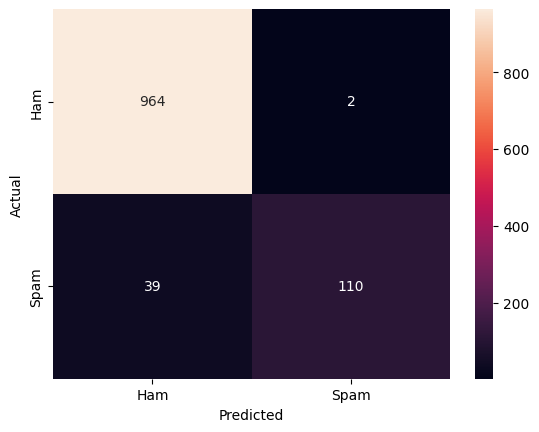

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [24]:
tfidf_df = pd.DataFrame(
    X.toarray(),
    columns=vectorizer.get_feature_names_out()
)

In [25]:
"""tfidf_df = pd.DataFrame(
    X.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df.index
)

df = pd.concat([df, tfidf_df], axis=1)"""

'tfidf_df = pd.DataFrame(\n    X.toarray(),\n    columns=vectorizer.get_feature_names_out(),\n    index=df.index\n)\n\ndf = pd.concat([df, tfidf_df], axis=1)'

In [26]:
import re
import string
import pandas as pd
from tqdm import tqdm
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer
import spacy
nlp = spacy.load("en_core_web_sm")

tqdm.pandas()

def apply_stemming_lemmatization(text):
    if not isinstance(text, str) or not text.strip():
        return {
            "lemma": "",
            "porter": "",
            "lancaster": "",
            "snowball": ""
        }

    # Tokenize
    tokens = text.split()

    # Initialize stemmers and lemmatizer
    porter = PorterStemmer()
    lancaster = LancasterStemmer()
    snowball = SnowballStemmer("english")
    lemmatizer = WordNetLemmatizer()

    # Apply each technique
    lemma_out = [lemmatizer.lemmatize(w) for w in tokens]
    porter_out = [porter.stem(w) for w in tokens]
    lancaster_out = [lancaster.stem(w) for w in tokens]
    snowball_out = [snowball.stem(w) for w in tokens]

    # Return all outputs
    return {
        "lemma": " ".join(lemma_out),
        "porter": " ".join(porter_out),
        "lancaster": " ".join(lancaster_out),
        "snowball": " ".join(snowball_out)
    }


# Step 2: Apply stemming and lemmatization
print("\n=== Step 2: Applying Stemming/Lemmatization ===")
df_stemmed = df['cleaned_sms'].progress_apply(
    apply_stemming_lemmatization
).apply(pd.Series)


=== Step 2: Applying Stemming/Lemmatization ===


100%|██████████| 5574/5574 [00:06<00:00, 881.25it/s] 


In [27]:
df_stemmed

,lemma,porter,lancaster,snowball
0,go jurong point crazy available bugis great wo...,go jurong point crazi avail bugi great world l...,go jurong point crazy avail bug gre world la b...,go jurong point crazi avail bugi great world l...
1,ok lar joking wif oni,ok lar joke wif oni,ok lar jok wif on,ok lar joke wif oni
2,free entry wkly comp win fa cup final tkts twe...,free entri wkli comp win fa cup final tkt twen...,fre entry wkly comp win fa cup fin tkts twenty...,free entri wkli comp win fa cup final tkts twe...
3,dun say early hor already say,dun say earli hor alreadi say,dun say ear hor already say,dun say earli hor alreadi say
4,nah think go usf life around though,nah think goe usf live around though,nah think goe usf liv around though,nah think goe usf live around though
...,...,...,...,...
5569,second time tried contact pound prize claim ea...,second time tri contact pound prize claim easi...,second tim tri contact pound priz claim easy c...,second time tri contact pound prize claim easi...
5570,going esplanade fr home,go esplanad fr home,going esplanad fr hom,go esplanad fr home
5571,pity mood soany suggestion,piti mood soani suggest,pity mood soany suggest,piti mood soani suggest
5572,guy bitching acted like would interested buyin...,guy bitch act like would interest buy someth e...,guy bitch act lik would interest buy someth el...,guy bitch act like would interest buy someth e...


In [28]:
"""import spacy
nlp = spacy.load("en_core_web_sm")

df['lemmatized_sms'] = df['cleaned_sms'].progress_apply(
    lambda x: " ".join([t.lemma_ for t in nlp(x)])
)

import spacy
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.is_alpha])

df['lemmatized_message'] = df['cleaned_sms'].progress_apply(lemmatize_text)

from nltk.stem import PorterStemmer
import nltk

nltk.download('punkt')
stemmer = PorterStemmer()

def stem_text(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df['stemmed_sms'] = df['cleaned_sms'].progress_apply(stem_text)
"""

'import spacy\nnlp = spacy.load("en_core_web_sm")\n\ndf[\'lemmatized_sms\'] = df[\'cleaned_sms\'].progress_apply(\n    lambda x: " ".join([t.lemma_ for t in nlp(x)])\n)\n\nimport spacy\nnlp = spacy.load("en_core_web_sm")\n\ndef lemmatize_text(text):\n    doc = nlp(text)\n    return " ".join([token.lemma_ for token in doc if token.is_alpha])\n\ndf[\'lemmatized_message\'] = df[\'cleaned_sms\'].progress_apply(lemmatize_text)\n\nfrom nltk.stem import PorterStemmer\nimport nltk\n\nnltk.download(\'punkt\')\nstemmer = PorterStemmer()\n\ndef stem_text(text):\n    return " ".join([stemmer.stem(word) for word in text.split()])\n\ndf[\'stemmed_sms\'] = df[\'cleaned_sms\'].progress_apply(stem_text)\n'

In [29]:
df

,sms,label,expanded_sms,cleaned_sms,word_tokens,sentence_tokens
0,"Go until jurong point, crazy.. Available only ...",0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...,"[go, jurong, point, crazy, available, bugis, g...",[go jurong point crazy available bugis great w...
1,Ok lar... Joking wif u oni...\n,0,Ok lar... Joking wif you oni...\n,ok lar joking wif oni,"[ok, lar, joking, wif, oni]",[ok lar joking wif oni]
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts twe...,"[free, entry, wkly, comp, win, fa, cup, final,...",[free entry wkly comp win fa cup final tkts tw...
3,U dun say so early hor... U c already then say...,0,YOU dun say so early hor... YOU c already then...,dun say early hor already say,"[dun, say, early, hor, already, say]",[dun say early hor already say]
4,"Nah I don't think he goes to usf, he lives aro...",0,"Nah I do not think he goes to usf, he lives ar...",nah think goes usf lives around though,"[nah, think, goes, usf, lives, around, though]",[nah think goes usf lives around though]
...,...,...,...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,This is the second time we have tried 2 contac...,second time tried contact pound prize claim ea...,"[second, time, tried, contact, pound, prize, c...",[second time tried contact pound prize claim e...
5570,Will ü b going to esplanade fr home?\n,0,Will ü b going to esplanade fr home?\n,going esplanade fr home,"[going, esplanade, fr, home]",[going esplanade fr home]
5571,"Pity, * was in mood for that. So...any other s...",0,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestions,"[pity, mood, soany, suggestions]",[pity mood soany suggestions]
5572,The guy did some bitching but I acted like i'd...,0,The guy did some bitching but I acted like i w...,guy bitching acted like would interested buyin...,"[guy, bitching, acted, like, would, interested...",[guy bitching acted like would interested buyi...


In [30]:
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['sms'])
#bow_transformer = vectorizer.fit(df['sms'])

feature_names = vectorizer.get_feature_names_out()

#print(f"First 10 features: {feature_names[:10]}")
#print(f"Features 20-40: {feature_names[20:40]}")
#print(f"Total vocabulary size: {len(vectorizer.vocabulary_)}")
#print(f"\nFull vocabulary: {feature_names}")

# Convert to DataFrame for better visualization
bow_df = pd.DataFrame(X.toarray(), columns=feature_names)
#print(bow_df)

In [31]:
df

,sms,label,expanded_sms,cleaned_sms,word_tokens,sentence_tokens
0,"Go until jurong point, crazy.. Available only ...",0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...,"[go, jurong, point, crazy, available, bugis, g...",[go jurong point crazy available bugis great w...
1,Ok lar... Joking wif u oni...\n,0,Ok lar... Joking wif you oni...\n,ok lar joking wif oni,"[ok, lar, joking, wif, oni]",[ok lar joking wif oni]
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts twe...,"[free, entry, wkly, comp, win, fa, cup, final,...",[free entry wkly comp win fa cup final tkts tw...
3,U dun say so early hor... U c already then say...,0,YOU dun say so early hor... YOU c already then...,dun say early hor already say,"[dun, say, early, hor, already, say]",[dun say early hor already say]
4,"Nah I don't think he goes to usf, he lives aro...",0,"Nah I do not think he goes to usf, he lives ar...",nah think goes usf lives around though,"[nah, think, goes, usf, lives, around, though]",[nah think goes usf lives around though]
...,...,...,...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,This is the second time we have tried 2 contac...,second time tried contact pound prize claim ea...,"[second, time, tried, contact, pound, prize, c...",[second time tried contact pound prize claim e...
5570,Will ü b going to esplanade fr home?\n,0,Will ü b going to esplanade fr home?\n,going esplanade fr home,"[going, esplanade, fr, home]",[going esplanade fr home]
5571,"Pity, * was in mood for that. So...any other s...",0,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestions,"[pity, mood, soany, suggestions]",[pity mood soany suggestions]
5572,The guy did some bitching but I acted like i'd...,0,The guy did some bitching but I acted like i w...,guy bitching acted like would interested buyin...,"[guy, bitching, acted, like, would, interested...",[guy bitching acted like would interested buyi...


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [33]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

def vectorize_text(text):
    count_vec = CountVectorizer()
    bow = count_vec.fit_transform(text)
    tfidf_vec = TfidfVectorizer()
    tfidf = tfidf_vec.fit_transform(text)
    return bow , count_vec.get_feature_names_out() , tfidf , tfidf_vec.get_feature_names_out()

bow , bow_feature , tfidf ,tfidf_features = vectorize_text(df['cleaned_sms'])

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer()
X = bow_vectorizer.fit_transform(df['sms'])

sms_bow = bow_vectorizer.transform(df['sms'])

print(f"Shape of sparse matrix: {sms_bow.shape}")
print(f"Amount of non-zero occurrences: {sms_bow.nnz}")

Shape of sparse matrix: (5574, 8713)
Amount of non-zero occurrences: 74169


In [35]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(sms_bow)

sms_tfidf = tfidf_transformer.transform(sms_bow)
print(sms_tfidf.shape)

(5574, 8713)


In [36]:
from sklearn.model_selection import train_test_split

# Split the dataset to train and test sets
sms_train, sms_test, label_train, label_test = train_test_split(
    sms_tfidf, df["label"], test_size=0.2
)

print(f"train dataset features size: {sms_train.shape}")
print(f"train dataset label size: {label_train.shape}")

print(f"test dataset features size: {sms_test.shape}")
print(f"test dataset label size: {label_test.shape}")

train dataset features size: (4459, 8713)
train dataset label size: (4459,)
test dataset features size: (1115, 8713)
test dataset label size: (1115,)


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. Prepare data
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_sms'])
y = df['label']

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Train
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Evaluate
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

Accuracy: 0.9632
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       0.98      0.74      0.84       149

    accuracy                           0.96      1115
   macro avg       0.97      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [38]:
from sklearn.feature_extraction.text import CountVectorizer

cv_lemma = CountVectorizer(max_features=3000)
X_bow_lemma = cv_lemma.fit_transform(
    df_stemmed['lemma']
).toarray()

y_bow = df['label'].values

print("BoW (lemmatized) shape:", X_bow_lemma.shape)

cv_stem = CountVectorizer(max_features=3000)
X_bow_stem = cv_stem.fit_transform(
    df_stemmed['porter']
).toarray()

print("BoW (stemmed) shape:", X_bow_stem.shape)

BoW (lemmatized) shape: (5574, 3000)
BoW (stemmed) shape: (5574, 3000)


In [39]:
"""LOGISTIC REGRESSION"""
"""
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

new_sms_bow = bow_vectorizer.transform(df['cleaned_sms'])

new_sms_tfidf = tfidf_transformer.transform(new_sms_bow)

prediction = model.predict(new_sms_tfidf)
print(prediction)"

new_sms_bow = bow_vectorizer.transform(df['cleaned_sms'])
new_sms_tfidf = tfidf_transformer.transform(new_sms_bow)

prediction = model.predict(new_sms_tfidf)


vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['cleaned_sms'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

new_sms = ["Free prize call now"]
new_sms_vec = vectorizer.transform(new_sms)
prediction = model.predict(new_sms_vec)

new_sms_bow = bow_vectorizer.transform(df['cleaned_sms'])
new_sms_tfidf = tfidf_transformer.transform(new_sms_bow)
prediction = model.predict(new_sms_tfidf)

if (prediction[0]==1):
  print('Ham mail')

else:
  print('Spam mail')"""

'\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.linear_model import LogisticRegression\n\nnew_sms_bow = bow_vectorizer.transform(df[\'cleaned_sms\'])\n\nnew_sms_tfidf = tfidf_transformer.transform(new_sms_bow)\n\nprediction = model.predict(new_sms_tfidf)\nprint(prediction)"\n\nnew_sms_bow = bow_vectorizer.transform(df[\'cleaned_sms\'])\nnew_sms_tfidf = tfidf_transformer.transform(new_sms_bow)\n\nprediction = model.predict(new_sms_tfidf)\n\n\nvectorizer = TfidfVectorizer(stop_words=\'english\')\nX = vectorizer.fit_transform(df[\'cleaned_sms\'])\ny = df[\'label\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)\n\nmodel = LogisticRegression(max_iter=1000)\nmodel.fit(X_train, y_train)\n\nnew_sms = ["Free prize call now"]\nnew_sms_vec = vectorizer.transform(new_sms)\nprediction = model.predict(new_sms_vec)\n\nnew_sms_bow = bow_vectorizer.transform(df[\'cleaned_sms\'])\nnew_sms_tfi

In [40]:
from collections import Counter
import nltk

def create_vocabulary(texts, min_freq=2, max_vocab_size=10000):
    all_tokens = []
    for text in texts:
        tokens = nltk.word_tokenize(text.lower())
        all_tokens.extend(tokens)

    token_counts = Counter(all_tokens)
    # Fix the typo here
    vocab = {token: count for token, count in token_counts.most_common(max_vocab_size) if count >= min_freq}
    
    token2id = {token: idx for idx, (token, _) in enumerate(vocab.items())}
    id2token = {idx: token for token, idx in token2id.items()}

    return vocab, token2id, id2token

vocab, token2id, id2token = create_vocabulary(df['cleaned_sms'], min_freq=2)

In [41]:
import pandas as pd

df_vocab2 = pd.DataFrame({
    'vocab': [vocab],
    'token2id': [token2id],
    'id2token': [id2token]
})

df_vocab2

,vocab,token2id,id2token
0,"{'call': 580, 'get': 390, 'know': 292, 'go': 2...","{'call': 0, 'get': 1, 'know': 2, 'go': 3, 'ok'...","{0: 'call', 1: 'get', 2: 'know', 3: 'go', 4: '..."


In [42]:
import pandas as pd

# Build DataFrame from vocab
df_vocab = pd.DataFrame({
    'token': list(vocab.keys()),
    'count': list(vocab.values()),
    'id': [token2id[token] for token in vocab.keys()]
})

# Optional: sort by id
df_vocab = df_vocab.sort_values('id').reset_index(drop=True)

In [43]:
df_vocab

,token,count,id
0,call,580,0
1,get,390,1
2,know,292,2
3,go,285,3
4,ok,278,4
...,...,...,...
3770,favorite,2,3770
3771,eggs,2,3771
3772,amused,2,3772
3773,shu,2,3773


In [44]:
from nltk import pos_tag

def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [45]:
df['prediction_log'] = model.predict(X)

In [46]:
df['prediction_label'] = df['prediction_log'].map({1: 'Ham', 0: 'Spam'})
df['true_label'] = df['label'].map({1: 'Ham', 0: 'Spam'})

In [47]:
wrong_preds = df[df['true_label'] != df['prediction_label']]
X = vectorizer.fit_transform(df['cleaned_sms'])
#wrong_preds[['sms','cleaned_sms' ,'true_label', 'prediction_label']].head(20)
wrong_preds[['sms','cleaned_sms' ,'true_label', 'prediction_label']]

,sms,cleaned_sms,true_label,prediction_label
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling weeks word back would like...,Ham,Spam
19,England v Macedonia - dont miss the goals/team...,england macedonia miss goalsteam news txt nati...,Ham,Spam
56,Congrats! 1 year special cinema pass for 2 is ...,congrats year special cinema pass call suprman...,Ham,Spam
68,"Did you hear about the new ""Divorce Barbie""? I...",hear new divorce barbie comes kens stuff,Ham,Spam
135,Want 2 get laid tonight? Want real Dogging loc...,want get laid tonight want real dogging locati...,Ham,Spam
...,...,...,...,...
5458,"""For the most sparkling shopping breaks from 4...",sparkling shopping breaks per person call visit,Ham,Spam
5468,http//tms. widelive.com/index. wml?id=820554ad...,widelivecomindex wmlidadafirsttrue¡c ringtone¡,Ham,Spam
5469,Get your garden ready for summer with a FREE s...,get garden ready summer free selection summer ...,Ham,Spam
5539,Want explicit SEX in 30 secs? Ring 02073162414...,want explicit sex secs ring costs pmin gsex po...,Ham,Spam


In [48]:
wrong_spam = wrong_preds[wrong_preds['true_label'] == 'Spam']
wrong_spam[['sms', 'cleaned_sms', 'true_label', 'prediction_label']]

,sms,cleaned_sms,true_label,prediction_label
495,Are you free now?can i call now?\n,free nowcan call,Spam,Ham
670,Did u receive my msg?\n,receive message,Spam,Ham
700,K..u also dont msg or reply to his msg..\n,kyou also message reply message,Spam,Ham
3364,Can... I'm free...\n,free,Spam,Ham
3589,If you were/are free i can give. Otherwise nal...,wereare free give otherwise nalla adi entey na...,Spam,Ham
4058,Noice. Text me when you're here\n,noice text,Spam,Ham
4419,"When you get free, call me\n",get free call,Spam,Ham
4702,I liked the new mobile\n,liked new mobile,Spam,Ham


In [49]:
wrong_ham = wrong_preds[wrong_preds['true_label'] == 'Ham']
wrong_ham[['sms', 'cleaned_sms', 'true_label', 'prediction_label']]

,sms,cleaned_sms,true_label,prediction_label
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling weeks word back would like...,Ham,Spam
19,England v Macedonia - dont miss the goals/team...,england macedonia miss goalsteam news txt nati...,Ham,Spam
56,Congrats! 1 year special cinema pass for 2 is ...,congrats year special cinema pass call suprman...,Ham,Spam
68,"Did you hear about the new ""Divorce Barbie""? I...",hear new divorce barbie comes kens stuff,Ham,Spam
135,Want 2 get laid tonight? Want real Dogging loc...,want get laid tonight want real dogging locati...,Ham,Spam
...,...,...,...,...
5458,"""For the most sparkling shopping breaks from 4...",sparkling shopping breaks per person call visit,Ham,Spam
5468,http//tms. widelive.com/index. wml?id=820554ad...,widelivecomindex wmlidadafirsttrue¡c ringtone¡,Ham,Spam
5469,Get your garden ready for summer with a FREE s...,get garden ready summer free selection summer ...,Ham,Spam
5539,Want explicit SEX in 30 secs? Ring 02073162414...,want explicit sex secs ring costs pmin gsex po...,Ham,Spam


In [50]:
# After analyzing misclassifications, here are improvement strategies:

# 1. ANALYZE MISCLASSIFICATION PATTERNS
print("=== Misclassification Analysis ===")
print(f"Total Errors: {len(wrong_preds)}")
print(f"Ham classified as Spam: {len(wrong_ham)}")
print(f"Spam classified as Ham: {len(wrong_spam)}")

# 2. BUILD SEPARATE VOCABULARIES (Optional - Advanced)
# This is useful if spam/ham have very different word distributions
from sklearn.feature_extraction.text import TfidfVectorizer

spam_texts = df[df['label'] == 0]['cleaned_sms']
ham_texts = df[df['label'] == 1]['cleaned_sms']

# Create separate vectorizers
spam_vectorizer = TfidfVectorizer(max_features=500)
ham_vectorizer = TfidfVectorizer(max_features=500)

spam_vocab = spam_vectorizer.fit_transform(spam_texts)
ham_vocab = ham_vectorizer.fit_transform(ham_texts)

print(f"\nSpam vocab size: {len(spam_vectorizer.get_feature_names_out())}")
print(f"Ham vocab size: {len(ham_vectorizer.get_feature_names_out())}")

# 3. ANALYZE COMMON MISCLASSIFIED WORDS
from collections import Counter
import pandas as pd

# Words that appear in wrongly classified ham (classified as spam)
wrong_ham_words = ' '.join(wrong_ham['cleaned_sms']).split()
ham_word_freq = Counter(wrong_ham_words).most_common(20)

print("\n=== Top 20 words in HAM emails classified as SPAM ===")
for word, count in ham_word_freq:
    print(f"{word}: {count}")

# Words that appear in wrongly classified spam (classified as ham)
wrong_spam_words = ' '.join(wrong_spam['cleaned_sms']).split()
spam_word_freq = Counter(wrong_spam_words).most_common(20)

print("\n=== Top 20 words in SPAM emails classified as HAM ===")
for word, count in spam_word_freq:
    print(f"{word}: {count}")

# 4. IMPROVE THE MODEL - Try different approaches:

# APPROACH A: Add domain-specific stopwords
custom_stopwords = {'click', 'call', 'email', 'contact', 'free', 'offer'}
# Retrain with these filtered out

# APPROACH B: Use different models
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# You can try these models:
models = {
    'Multinomial NB': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# APPROACH C: Adjust class weights (if imbalanced)
# model = LogisticRegression(class_weight='balanced')

# APPROACH D: Feature engineering
# Add features like:
# - Message length
# - Number of special characters
# - Presence of URLs/emails
# - ALL CAPS ratio

df['msg_length'] = df['sms'].str.len()
df['special_char_ratio'] = df['sms'].apply(
    lambda x: sum(1 for c in x if c in '!@#$%^&*()') / len(x) if len(x) > 0 else 0
)
df['uppercase_ratio'] = df['sms'].apply(
    lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
)

# Combine text features with engineered features
from scipy.sparse import hstack
X_text = vectorizer.fit_transform(df['cleaned_sms'])
X_features = df[['msg_length', 'special_char_ratio', 'uppercase_ratio']]
X_combined = hstack([X_text, X_features])

# APPROACH E: Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'penalty': ['l2']}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
# grid_search.fit(X_combined, df['label'])

# 5. EVALUATE IMPROVEMENTS
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# predictions = grid_search.predict(X_combined)
# print("\n=== Classification Report ===")
# print(classification_report(df['label'], predictions, target_names=['Spam', 'Ham']))
# print("\nConfusion Matrix:")
# print(confusion_matrix(df['label'], predictions))

=== Misclassification Analysis ===
Total Errors: 180
Ham classified as Spam: 172
Spam classified as Ham: 8

Spam vocab size: 500
Ham vocab size: 500

=== Top 20 words in HAM emails classified as SPAM ===
call: 45
text: 19
send: 18
free: 17
want: 17
get: 16
back: 12
next: 12
hi: 12
stop: 12
reply: 12
chat: 12
txt: 11
know: 11
go: 11
new: 10
love: 10
day: 10
like: 9
name: 9

=== Top 20 words in SPAM emails classified as HAM ===
free: 4
message: 3
call: 2
nowcan: 1
receive: 1
kyou: 1
also: 1
reply: 1
wereare: 1
give: 1
otherwise: 1
nalla: 1
adi: 1
entey: 1
nattil: 1
kittum: 1
noice: 1
text: 1
get: 1
liked: 1


In [51]:
from collections import Counter
import pandas as pd

# 1. EXTRACT SPAM AND HAM TEXTS
spam_texts = df[df['label'] == 0]['cleaned_sms']
ham_texts = df[df['label'] == 1]['cleaned_sms']

# 2. CREATE WORD LISTS FOR EACH CATEGORY
spam_words = ' '.join(spam_texts).split()
ham_words = ' '.join(ham_texts).split()

spam_word_set = set(spam_words)
ham_word_set = set(ham_words)

# 3. FIND COMMON WORDS (appear in both spam and ham)
common_words = spam_word_set.intersection(ham_word_set)
print(f"=== VOCABULARY ANALYSIS ===")
print(f"Total unique words in SPAM: {len(spam_word_set)}")
print(f"Total unique words in HAM: {len(ham_word_set)}")
print(f"Common words (in both): {len(common_words)}")
print(f"\nSpam-only words: {len(spam_word_set - ham_word_set)}")
print(f"Ham-only words: {len(ham_word_set - spam_word_set)}")

# 4. FIND MOST COMMON WORDS IN EACH CATEGORY
spam_counter = Counter(spam_words)
ham_counter = Counter(ham_words)

print("\n=== TOP 20 SPAM WORDS ===")
spam_top_20 = spam_counter.most_common(20)
spam_df = pd.DataFrame(spam_top_20, columns=['word', 'count'])
print(spam_df.to_string(index=False))

print("\n=== TOP 20 HAM WORDS ===")
ham_top_20 = ham_counter.most_common(20)
ham_df = pd.DataFrame(ham_top_20, columns=['word', 'count'])
print(ham_df.to_string(index=False))

# 5. SHOW COMMON WORDS WITH THEIR FREQUENCIES
print("\n=== TOP 20 COMMON WORDS (in both SPAM & HAM) ===")
common_word_freq = [(word, spam_counter[word], ham_counter[word]) 
                     for word in sorted(common_words, 
                                       key=lambda w: spam_counter[w] + ham_counter[w], 
                                       reverse=True)[:20]]

common_words_df = pd.DataFrame(common_word_freq, 
                               columns=['word', 'spam_count', 'ham_count'])
common_words_df['total'] = common_words_df['spam_count'] + common_words_df['ham_count']
print(common_words_df.to_string(index=False))

# 6. REMOVE COMMON WORDS FROM SPAM VOCAB
spam_only_words = spam_word_set - ham_word_set
print(f"\n=== SPAM-ONLY WORDS (top 30) ===")
spam_only_freq = [(word, spam_counter[word]) for word in spam_only_words]
spam_only_freq.sort(key=lambda x: x[1], reverse=True)
spam_only_df = pd.DataFrame(spam_only_freq[:30], columns=['word', 'count'])
print(spam_only_df.to_string(index=False))

# 7. REMOVE COMMON WORDS FROM HAM VOCAB
ham_only_words = ham_word_set - spam_word_set
print(f"\n=== HAM-ONLY WORDS (top 30) ===")
ham_only_freq = [(word, ham_counter[word]) for word in ham_only_words]
ham_only_freq.sort(key=lambda x: x[1], reverse=True)
ham_only_df = pd.DataFrame(ham_only_freq[:30], columns=['word', 'count'])
print(ham_only_df.to_string(index=False))

# 8. CREATE FILTERED TEXTS (removing common words)
print("\n\n=== CREATING FILTERED VOCABULARIES ===")

# Create filtered spam text (remove common words)
filtered_spam_texts = spam_texts.apply(
    lambda x: ' '.join([word for word in x.split() if word not in common_words])
)

# Create filtered ham text (remove common words)
filtered_ham_texts = ham_texts.apply(
    lambda x: ' '.join([word for word in x.split() if word not in common_words])
)

# Add to dataframe
df.loc[df['label'] == 0, 'filtered_text'] = filtered_spam_texts
df.loc[df['label'] == 1, 'filtered_text'] = filtered_ham_texts

print(f"Filtered texts created!")
print(f"\nBefore filtering - Sample spam text:")
print(f"{spam_texts.iloc[0]}")
print(f"\nAfter filtering - Sample spam text:")
print(f"{filtered_spam_texts.iloc[0]}")

# 9. RETRAIN MODEL WITH FILTERED VOCABULARY
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create new vectorizer with filtered texts
vectorizer_filtered = TfidfVectorizer(max_features=1000)
X_filtered = vectorizer_filtered.fit_transform(df['filtered_text'])

X_train_f, X_test_f, y_train, y_test = train_test_split(
    X_filtered, df['label'], test_size=0.2, random_state=42
)

# Train new model
model_filtered = MultinomialNB()
model_filtered.fit(X_train_f, y_train)

# Predictions
y_pred_filtered = model_filtered.predict(X_test_f)

print("\n=== MODEL PERFORMANCE WITH FILTERED VOCABULARY ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_filtered):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_filtered, target_names=['Spam', 'Ham']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_filtered))

# Compare with original model if you have it
# print("\n=== COMPARISON ===")
# original_accuracy = original_model_accuracy
# print(f"Original model accuracy: {original_accuracy:.4f}")
# print(f"Filtered model accuracy: {accuracy_score(y_test, y_pred_filtered):.4f}")

=== VOCABULARY ANALYSIS ===
Total unique words in SPAM: 7183
Total unique words in HAM: 2063
Common words (in both): 891

Spam-only words: 6292
Ham-only words: 1172

=== TOP 20 SPAM WORDS ===
 word  count
  get    307
 ltgt    276
   ok    273
 know    267
   go    252
  got    245
going    232
 like    231
 call    231
 come    227
 good    224
 love    223
 want    192
  day    192
 time    189
  one    163
 home    160
  lor    160
 need    157
sorry    153

=== TOP 20 HAM WORDS ===
   word  count
   call    349
   free    219
    txt    150
 mobile    124
   text    121
   stop    118
  claim    113
  reply    101
  prize     92
    get     83
  nokia     69
    new     69
   send     68
 urgent     63
   cash     62
    win     61
message     59
contact     56
service     55
 please     54

=== TOP 20 COMMON WORDS (in both SPAM & HAM) ===
   word  spam_count  ham_count  total
   call         231        349    580
    get         307         83    390
   know         267         25

In [52]:
df

,sms,label,expanded_sms,cleaned_sms,word_tokens,sentence_tokens,prediction_log,prediction_label,true_label,msg_length,special_char_ratio,uppercase_ratio,filtered_text
0,"Go until jurong point, crazy.. Available only ...",0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...,"[go, jurong, point, crazy, available, bugis, g...",[go jurong point crazy available bugis great w...,0,Spam,Spam,112,0.000000,0.026786,jurong point bugis buffet cine amore
1,Ok lar... Joking wif u oni...\n,0,Ok lar... Joking wif you oni...\n,ok lar joking wif oni,"[ok, lar, joking, wif, oni]",[ok lar joking wif oni],0,Spam,Spam,30,0.000000,0.066667,lar joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts twe...,"[free, entry, wkly, comp, win, fa, cup, final,...",[free entry wkly comp win fa cup final tkts tw...,1,Ham,Ham,156,0.019231,0.064103,entry wkly fa tkts fa entry questionstd ratetc...
3,U dun say so early hor... U c already then say...,0,YOU dun say so early hor... YOU c already then...,dun say early hor already say,"[dun, say, early, hor, already, say]",[dun say early hor already say],0,Spam,Spam,50,0.000000,0.040000,dun early hor
4,"Nah I don't think he goes to usf, he lives aro...",0,"Nah I do not think he goes to usf, he lives ar...",nah think goes usf lives around though,"[nah, think, goes, usf, lives, around, though]",[nah think goes usf lives around though],0,Spam,Spam,62,0.000000,0.032258,nah goes usf lives though
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,This is the second time we have tried 2 contac...,second time tried contact pound prize claim ea...,"[second, time, tried, contact, pound, prize, c...",[second time tried contact pound prize claim e...,1,Ham,Ham,161,0.006211,0.055901,prize claim btnationalrate
5570,Will ü b going to esplanade fr home?\n,0,Will ü b going to esplanade fr home?\n,going esplanade fr home,"[going, esplanade, fr, home]",[going esplanade fr home],0,Spam,Spam,37,0.000000,0.027027,esplanade fr
5571,"Pity, * was in mood for that. So...any other s...",0,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestions,"[pity, mood, soany, suggestions]",[pity mood soany suggestions],0,Spam,Spam,58,0.017241,0.034483,pity mood soany suggestions
5572,The guy did some bitching but I acted like i'd...,0,The guy did some bitching but I acted like i w...,guy bitching acted like would interested buyin...,"[guy, bitching, acted, like, would, interested...",[guy bitching acted like would interested buyi...,0,Spam,Spam,126,0.000000,0.015873,guy bitching acted interested buying something...


In [53]:
import pandas as pd

spam_texts = df.loc[df['label'] == 1, 'cleaned_sms']

spam_vocab, spam_token2id, spam_id2token = create_vocabulary(
    spam_texts,
    min_freq=2,
    max_vocab_size=10000
)

df_vocab_spam = pd.DataFrame(
    list(spam_vocab.items()),  # (token, count) pairs
    columns=['token', 'frequency']
)

df_vocab_spam['token_id'] = df_vocab_spam['token'].map(spam_token2id)
df_vocab_spam = df_vocab_spam[['token_id', 'token', 'frequency']]  # reorder columns

In [54]:
df_vocab_spam

,token_id,token,frequency
0,0,call,349
1,1,free,219
2,2,txt,150
3,3,mobile,124
4,4,text,121
...,...,...,...
1084,1084,seeds,2
1085,1085,scotsman,2
1086,1086,notxtcouk,2
1087,1087,maybe,2


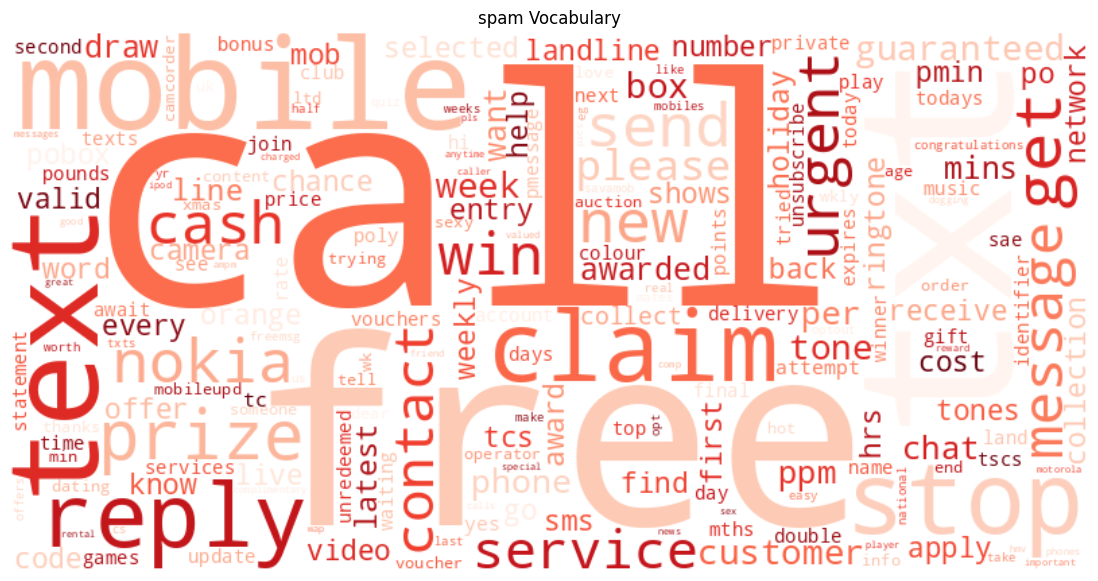

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

spam_dict = dict(zip(df_vocab_spam['token'], df_vocab_spam['frequency']))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'
).generate_from_frequencies(spam_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('spam Vocabulary')
plt.show()

In [56]:
import pandas as pd

ham_texts = df.loc[df['label'] == 0, 'cleaned_sms']

ham_vocab, ham_token2id, ham_id2token = create_vocabulary(
    ham_texts,
    min_freq=2,
    max_vocab_size=10000
)

df_vocab_ham = pd.DataFrame(
    list(ham_vocab.items()),  # (token, count) pairs
    columns=['token', 'frequency']
)

df_vocab_ham['token_id'] = df_vocab_ham['token'].map(ham_token2id)
df_vocab_ham = df_vocab_ham[['token_id', 'token', 'frequency']]

In [57]:
df_vocab_ham

,token_id,token,frequency
0,0,get,307
1,1,ltgt,276
2,2,ok,273
3,3,know,267
4,4,go,252
...,...,...,...
3087,3087,favorite,2
3088,3088,eggs,2
3089,3089,amused,2
3090,3090,shu,2


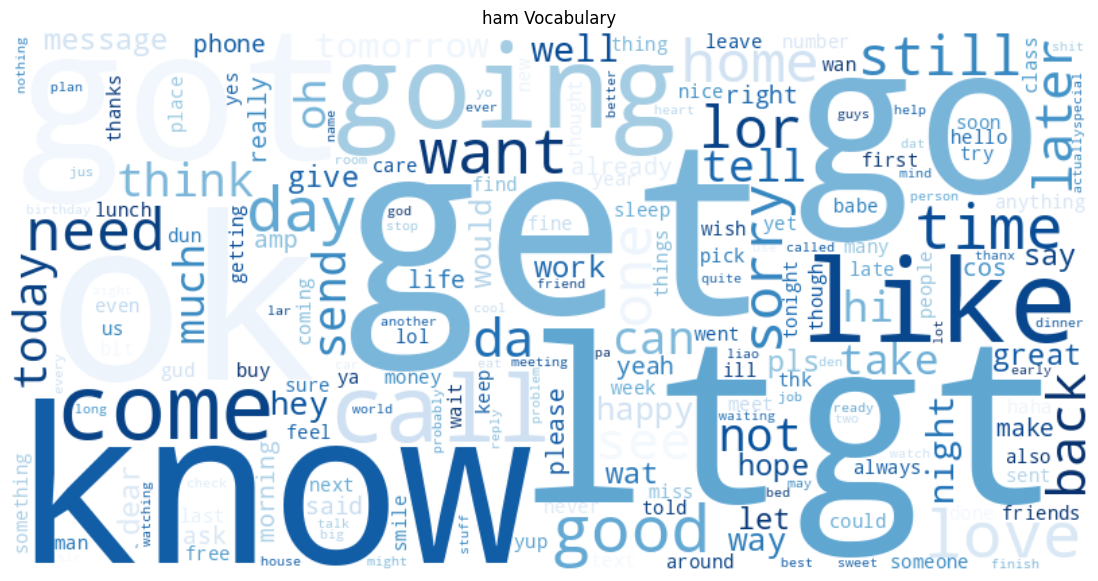

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

ham_dict = dict(zip(df_vocab_ham['token'], df_vocab_ham['frequency']))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Blues'
).generate_from_frequencies(ham_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('ham Vocabulary')
plt.show()

In [59]:
X = vectorizer.fit_transform(df['cleaned_sms'])
y = df['label']   # spam / ham

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X, y)

LogisticRegression(max_iter=1000)

In [60]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Dictionary of models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = {}

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    """
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    """

# Compare results
results_df = pd.DataFrame(results).T
print("\n=== Model Comparison ===")
print(results_df.sort_values('Accuracy', ascending=False))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== Model Comparison ===
                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.855605   0.000000  0.000000  0.000000
Naive Bayes          0.854709   0.000000  0.000000  0.000000
KNN                  0.853812   0.250000  0.006211  0.012121
Gradient Boosting    0.853812   0.000000  0.000000  0.000000
SVM                  0.852915   0.000000  0.000000  0.000000
Random Forest        0.827803   0.183673  0.055901  0.085714
Decision Tree        0.790135   0.176991  0.124224  0.145985


In [61]:
import numpy as np
import nltk

def text_to_bow(text, token2id):
    vec = np.zeros(len(token2id), dtype=int)
    tokens = nltk.word_tokenize(text.lower())
    
    for token in tokens:
        if token in token2id:
            vec[token2id[token]] += 1
    return vec

X = np.array([
    text_to_bow(text, token2id)
    for text in df['cleaned_sms']
])

y = df['label'].values   # spam / ham

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

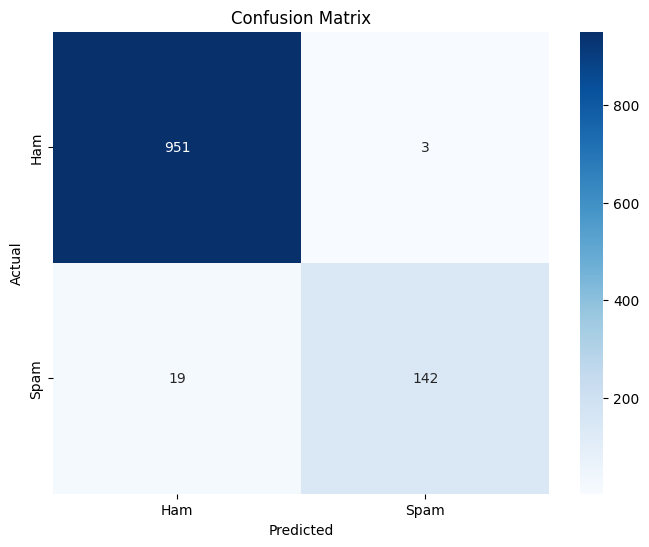


=== Classification Report ===
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       954
        Spam       0.98      0.88      0.93       161

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



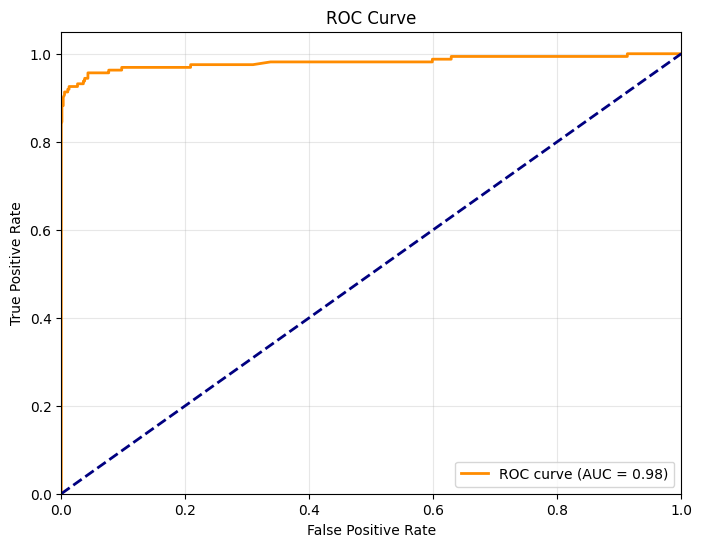

In [63]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# best_model = MultinomialNB()
#best_model = SVC(kernel='linear')
#best_model.fit(X_train, y_train)
best_model = SVC(kernel='linear', probability=True)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

# ROC Curve
from sklearn.metrics import roc_curve, auc

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [64]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9820627802690582
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       954
           1       1.00      0.88      0.93       161

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [65]:
df

,sms,label,expanded_sms,cleaned_sms,word_tokens,sentence_tokens,prediction_log,prediction_label,true_label,msg_length,special_char_ratio,uppercase_ratio,filtered_text
0,"Go until jurong point, crazy.. Available only ...",0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...,"[go, jurong, point, crazy, available, bugis, g...",[go jurong point crazy available bugis great w...,0,Spam,Spam,112,0.000000,0.026786,jurong point bugis buffet cine amore
1,Ok lar... Joking wif u oni...\n,0,Ok lar... Joking wif you oni...\n,ok lar joking wif oni,"[ok, lar, joking, wif, oni]",[ok lar joking wif oni],0,Spam,Spam,30,0.000000,0.066667,lar joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts twe...,"[free, entry, wkly, comp, win, fa, cup, final,...",[free entry wkly comp win fa cup final tkts tw...,1,Ham,Ham,156,0.019231,0.064103,entry wkly fa tkts fa entry questionstd ratetc...
3,U dun say so early hor... U c already then say...,0,YOU dun say so early hor... YOU c already then...,dun say early hor already say,"[dun, say, early, hor, already, say]",[dun say early hor already say],0,Spam,Spam,50,0.000000,0.040000,dun early hor
4,"Nah I don't think he goes to usf, he lives aro...",0,"Nah I do not think he goes to usf, he lives ar...",nah think goes usf lives around though,"[nah, think, goes, usf, lives, around, though]",[nah think goes usf lives around though],0,Spam,Spam,62,0.000000,0.032258,nah goes usf lives though
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,This is the second time we have tried 2 contac...,second time tried contact pound prize claim ea...,"[second, time, tried, contact, pound, prize, c...",[second time tried contact pound prize claim e...,1,Ham,Ham,161,0.006211,0.055901,prize claim btnationalrate
5570,Will ü b going to esplanade fr home?\n,0,Will ü b going to esplanade fr home?\n,going esplanade fr home,"[going, esplanade, fr, home]",[going esplanade fr home],0,Spam,Spam,37,0.000000,0.027027,esplanade fr
5571,"Pity, * was in mood for that. So...any other s...",0,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestions,"[pity, mood, soany, suggestions]",[pity mood soany suggestions],0,Spam,Spam,58,0.017241,0.034483,pity mood soany suggestions
5572,The guy did some bitching but I acted like i'd...,0,The guy did some bitching but I acted like i w...,guy bitching acted like would interested buyin...,"[guy, bitching, acted, like, would, interested...",[guy bitching acted like would interested buyi...,0,Spam,Spam,126,0.000000,0.015873,guy bitching acted interested buying something...


In [66]:
df_stemmed

,lemma,porter,lancaster,snowball
0,go jurong point crazy available bugis great wo...,go jurong point crazi avail bugi great world l...,go jurong point crazy avail bug gre world la b...,go jurong point crazi avail bugi great world l...
1,ok lar joking wif oni,ok lar joke wif oni,ok lar jok wif on,ok lar joke wif oni
2,free entry wkly comp win fa cup final tkts twe...,free entri wkli comp win fa cup final tkt twen...,fre entry wkly comp win fa cup fin tkts twenty...,free entri wkli comp win fa cup final tkts twe...
3,dun say early hor already say,dun say earli hor alreadi say,dun say ear hor already say,dun say earli hor alreadi say
4,nah think go usf life around though,nah think goe usf live around though,nah think goe usf liv around though,nah think goe usf live around though
...,...,...,...,...
5569,second time tried contact pound prize claim ea...,second time tri contact pound prize claim easi...,second tim tri contact pound priz claim easy c...,second time tri contact pound prize claim easi...
5570,going esplanade fr home,go esplanad fr home,going esplanad fr hom,go esplanad fr home
5571,pity mood soany suggestion,piti mood soani suggest,pity mood soany suggest,piti mood soani suggest
5572,guy bitching acted like would interested buyin...,guy bitch act like would interest buy someth e...,guy bitch act lik would interest buy someth el...,guy bitch act like would interest buy someth e...


In [67]:
# Install xgboost library
!pip install xgboost

In [68]:
# Train an xgboost classifier
from xgboost import XGBClassifier

clf = XGBClassifier()

clf.fit(sms_train, label_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [69]:
from sklearn import metrics

label_predictions = clf.predict(sms_test)
print(f"Accuracy of the model: {metrics.accuracy_score(label_test, label_predictions):0.3f}")

Accuracy of the model: 0.978


In [70]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [71]:
def predict_sms(text):
    vec = text_to_bow(text, token2id).reshape(1, -1)
    return model.predict(vec)[0]

predict_sms("Congratulations! You won a free prize")
predict_sms("Hey, are we meeting today?")

0

=== Cross-Validation Results (5-Fold) ===
Accuracy:  0.9785 (+/- 0.0087)
Precision: 0.9874 (+/- 0.0216)
Recall:    0.8501 (+/- 0.0484)
F1-Score:  0.9135 (+/- 0.0365)


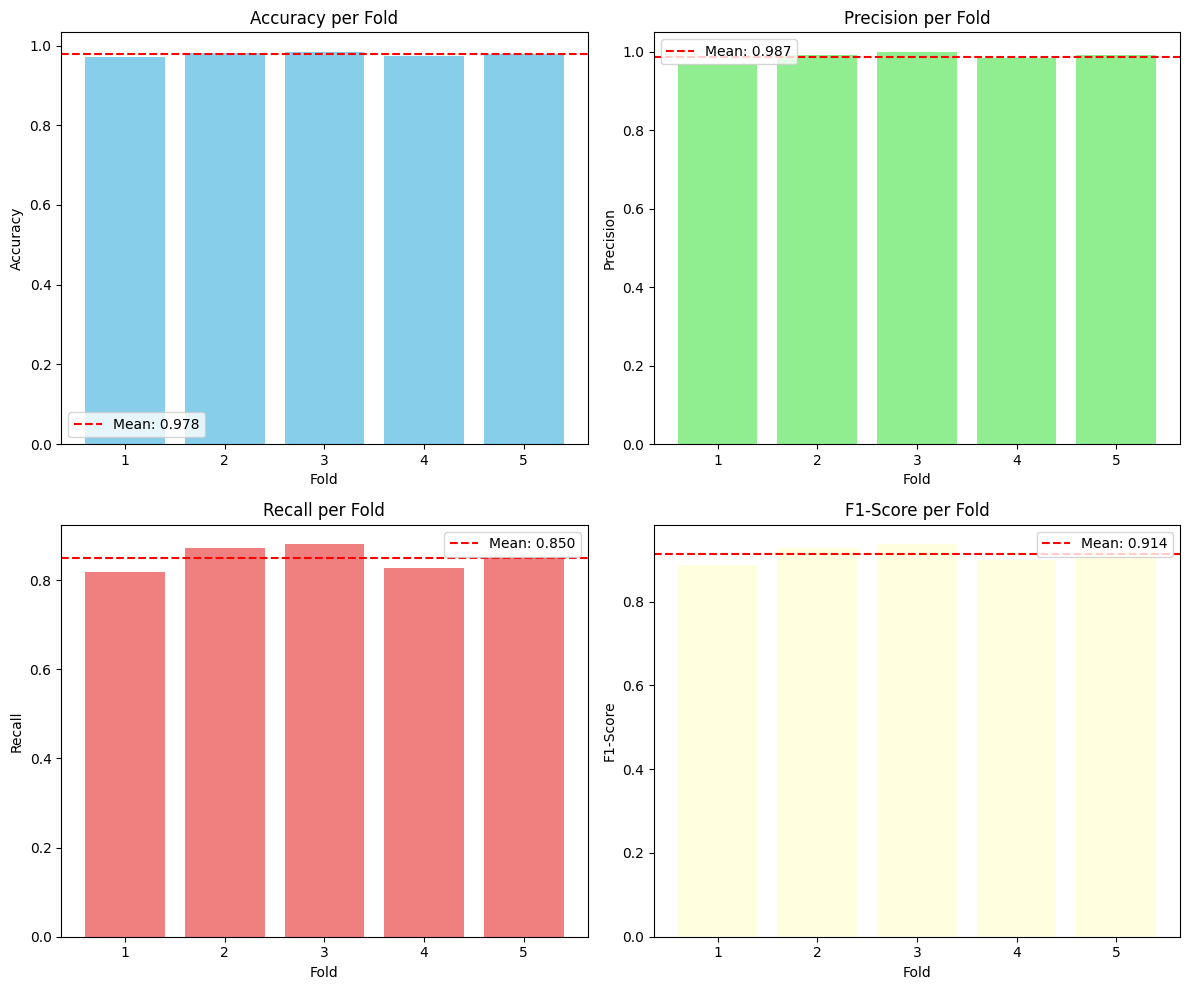

In [72]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

# Perform k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate cross-validation scores
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(model, X, y, cv=cv, scoring='precision')
cv_recall = cross_val_score(model, X, y, cv=cv, scoring='recall')
cv_f1 = cross_val_score(model, X, y, cv=cv, scoring='f1')

print("=== Cross-Validation Results (5-Fold) ===")
print(f"Accuracy:  {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Precision: {cv_precision.mean():.4f} (+/- {cv_precision.std() * 2:.4f})")
print(f"Recall:    {cv_recall.mean():.4f} (+/- {cv_recall.std() * 2:.4f})")
print(f"F1-Score:  {cv_f1.mean():.4f} (+/- {cv_f1.std() * 2:.4f})")

# Visualize CV scores
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].bar(range(1, 6), cv_scores, color='skyblue')
axes[0, 0].axhline(cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.3f}')
axes[0, 0].set_title('Accuracy per Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

axes[0, 1].bar(range(1, 6), cv_precision, color='lightgreen')
axes[0, 1].axhline(cv_precision.mean(), color='red', linestyle='--', label=f'Mean: {cv_precision.mean():.3f}')
axes[0, 1].set_title('Precision per Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].legend()

axes[1, 0].bar(range(1, 6), cv_recall, color='lightcoral')
axes[1, 0].axhline(cv_recall.mean(), color='red', linestyle='--', label=f'Mean: {cv_recall.mean():.3f}')
axes[1, 0].set_title('Recall per Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()

axes[1, 1].bar(range(1, 6), cv_f1, color='lightyellow')
axes[1, 1].axhline(cv_f1.mean(), color='red', linestyle='--', label=f'Mean: {cv_f1.mean():.3f}')
axes[1, 1].set_title('F1-Score per Fold')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

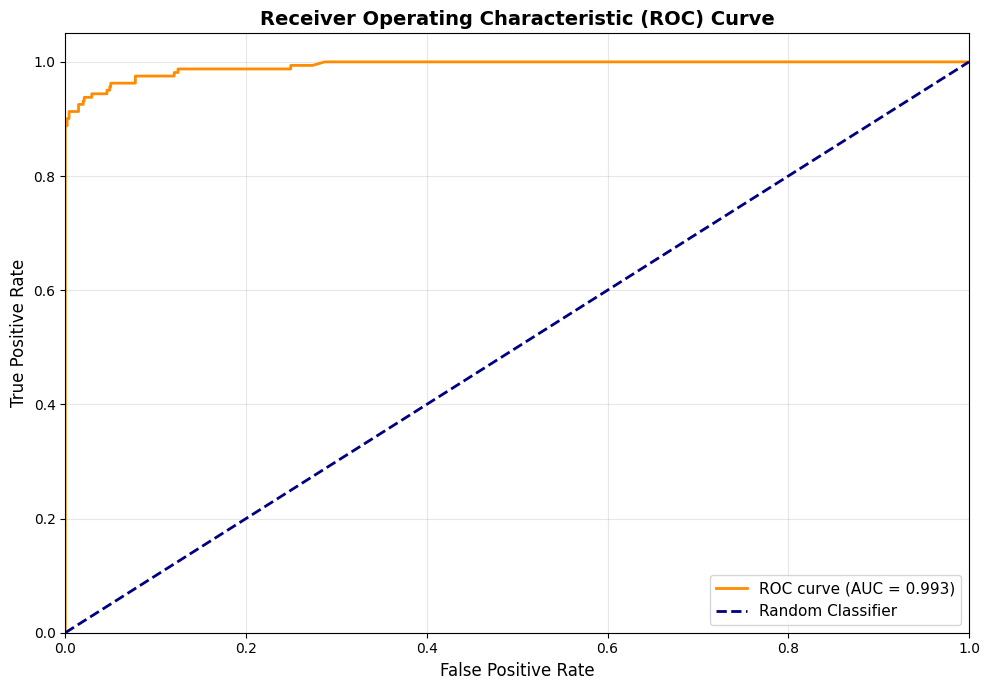

ROC-AUC Score: 0.9926


In [73]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Get probability predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

In [74]:
df

,sms,label,expanded_sms,cleaned_sms,word_tokens,sentence_tokens,prediction_log,prediction_label,true_label,msg_length,special_char_ratio,uppercase_ratio,filtered_text
0,"Go until jurong point, crazy.. Available only ...",0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...,"[go, jurong, point, crazy, available, bugis, g...",[go jurong point crazy available bugis great w...,0,Spam,Spam,112,0.000000,0.026786,jurong point bugis buffet cine amore
1,Ok lar... Joking wif u oni...\n,0,Ok lar... Joking wif you oni...\n,ok lar joking wif oni,"[ok, lar, joking, wif, oni]",[ok lar joking wif oni],0,Spam,Spam,30,0.000000,0.066667,lar joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts twe...,"[free, entry, wkly, comp, win, fa, cup, final,...",[free entry wkly comp win fa cup final tkts tw...,1,Ham,Ham,156,0.019231,0.064103,entry wkly fa tkts fa entry questionstd ratetc...
3,U dun say so early hor... U c already then say...,0,YOU dun say so early hor... YOU c already then...,dun say early hor already say,"[dun, say, early, hor, already, say]",[dun say early hor already say],0,Spam,Spam,50,0.000000,0.040000,dun early hor
4,"Nah I don't think he goes to usf, he lives aro...",0,"Nah I do not think he goes to usf, he lives ar...",nah think goes usf lives around though,"[nah, think, goes, usf, lives, around, though]",[nah think goes usf lives around though],0,Spam,Spam,62,0.000000,0.032258,nah goes usf lives though
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,This is the second time we have tried 2 contac...,second time tried contact pound prize claim ea...,"[second, time, tried, contact, pound, prize, c...",[second time tried contact pound prize claim e...,1,Ham,Ham,161,0.006211,0.055901,prize claim btnationalrate
5570,Will ü b going to esplanade fr home?\n,0,Will ü b going to esplanade fr home?\n,going esplanade fr home,"[going, esplanade, fr, home]",[going esplanade fr home],0,Spam,Spam,37,0.000000,0.027027,esplanade fr
5571,"Pity, * was in mood for that. So...any other s...",0,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestions,"[pity, mood, soany, suggestions]",[pity mood soany suggestions],0,Spam,Spam,58,0.017241,0.034483,pity mood soany suggestions
5572,The guy did some bitching but I acted like i'd...,0,The guy did some bitching but I acted like i w...,guy bitching acted like would interested buyin...,"[guy, bitching, acted, like, would, interested...",[guy bitching acted like would interested buyi...,0,Spam,Spam,126,0.000000,0.015873,guy bitching acted interested buying something...


In [75]:
import spacy
import pandas as pd
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")
print("✓ Model loaded!\n")

# Define function WITHOUT loading model each time
def extract_entities(text):
    if pd.isna(text):
        return []
    try:
        doc = nlp(text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        return entities
    except:
        return []

# Apply to dataframe
print("Extracting entities...")
entities = df['expanded_sms'].progress_apply(extract_entities)
print("✓ Done!\n")

# View results
print("Sample entities:")
print(entities.head())

✓ Model loaded!

Extracting entities...


100%|██████████| 5574/5574 [00:57<00:00, 96.38it/s] 

✓ Done!

Sample entities:
0                                     [(Cine, PERSON)]
1                                                   []
2    [(2, CARDINAL), (FA Cup, EVENT), (twenty-first...
3                                                   []
4                                                   []
Name: expanded_sms, dtype: object


In [76]:
entities

0                                        [(Cine, PERSON)]
1                                                      []
2       [(2, CARDINAL), (FA Cup, EVENT), (twenty-first...
3                                                      []
4                                                      []
                              ...                        
5569    [(second, ORDINAL), (2, CARDINAL), (2, CARDINA...
5570                                                   []
5571                                                   []
5572                                  [(next week, DATE)]
5573                                                   []
Name: expanded_sms, Length: 5574, dtype: object

In [85]:
import spacy
import pandas as pd
from tqdm import tqdm
from collections import Counter

tqdm.pandas()

nlp = spacy.load("en_core_web_sm")
print("✓ Model loaded!\n")

# Define function WITHOUT loading model each time
def extract_entities(text):
    if pd.isna(text):
        return []
    try:
        doc = nlp(text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        return entities
    except:
        return []

# Apply to dataframe
print("Extracting entities...")
df['entities'] = df['cleaned_sms'].progress_apply(extract_entities)
print("✓ Done!\n")

# View results
print("Sample entities:")
print(df[['label', 'cleaned_sms', 'entities']].head(10))

# ============================================
# 1. SEPARATE ENTITIES BY SPAM/HAM
# ============================================
print("\n" + "="*60)
print("ENTITY ANALYSIS: SPAM vs HAM")
print("="*60)

spam_entities = df[df['label'] == 0]['entities']
ham_entities = df[df['label'] == 1]['entities']

# Flatten lists
spam_all_entities = [ent for row in spam_entities for ent in row]
ham_all_entities = [ent for row in ham_entities for ent in row]

print(f"\nTotal entities in SPAM messages: {len(spam_all_entities)}")
print(f"Total entities in HAM messages: {len(ham_all_entities)}")

# ============================================
# 2. ANALYZE ENTITY TYPES
# ============================================
print("\n" + "-"*60)
print("ENTITY TYPES DISTRIBUTION")
print("-"*60)

spam_entity_types = Counter([ent[1] for ent in spam_all_entities])
ham_entity_types = Counter([ent[1] for ent in ham_all_entities])

print("\nEntity types in SPAM (top 10):")
for entity_type, count in spam_entity_types.most_common(10):
    print(f"  {entity_type}: {count}")

print("\nEntity types in HAM (top 10):")
for entity_type, count in ham_entity_types.most_common(10):
    print(f"  {entity_type}: {count}")

# ============================================
# 3. TOP ENTITIES IN SPAM vs HAM
# ============================================
print("\n" + "-"*60)
print("TOP 20 ENTITIES IN SPAM")
print("-"*60)

spam_entity_counter = Counter(spam_all_entities)
spam_top = spam_entity_counter.most_common(20)
spam_entity_df = pd.DataFrame(spam_top, columns=['Entity (text, type)', 'Count'])
spam_entity_df[['Text', 'Type']] = pd.DataFrame(
    spam_entity_df['Entity (text, type)'].tolist(), index=spam_entity_df.index
)
print(spam_entity_df[['Text', 'Type', 'Count']].to_string(index=False))

print("\n" + "-"*60)
print("TOP 20 ENTITIES IN HAM")
print("-"*60)

ham_entity_counter = Counter(ham_all_entities)
ham_top = ham_entity_counter.most_common(20)
ham_entity_df = pd.DataFrame(ham_top, columns=['Entity (text, type)', 'Count'])
ham_entity_df[['Text', 'Type']] = pd.DataFrame(
    ham_entity_df['Entity (text, type)'].tolist(), index=ham_entity_df.index
)
print(ham_entity_df[['Text', 'Type', 'Count']].to_string(index=False))

# ============================================
# 4. SPAM-ONLY ENTITIES (without common ones)
# ============================================
spam_entity_set = set(spam_all_entities)
ham_entity_set = set(ham_all_entities)
spam_only_entities = spam_entity_set - ham_entity_set
print("\n" + "-"*60)
print("SPAM-ONLY ENTITIES (top 20)")
print("-"*60)
spam_only_freq = [(ent, spam_entity_counter[ent]) for ent in spam_only_entities]
spam_only_freq.sort(key=lambda x: x[1], reverse=True)
spam_only_df = pd.DataFrame(spam_only_freq[:20], columns=['Entity', 'Count'])
print(spam_only_df.to_string(index=False))

# ============================================
# 6. HAM-ONLY ENTITIES
# ============================================
ham_only_entities = ham_entity_set - spam_entity_set
print("\n" + "-"*60)
print("HAM-ONLY ENTITIES (top 20)")
print("-"*60)
ham_only_freq = [(ent, ham_entity_counter[ent]) for ent in ham_only_entities]
ham_only_freq.sort(key=lambda x: x[1], reverse=True)
ham_only_df = pd.DataFrame(ham_only_freq[:20], columns=['Entity', 'Count'])
print(ham_only_df.to_string(index=False))

# ============================================
# 7. CREATE FEATURES FROM ENTITIES
# ============================================
print("\n" + "="*60)
print("CREATING ENTITY FEATURES")
print("="*60)

# Count entities per message
df['entity_count'] = df['entities'].apply(len)

# Count each entity type per message
df['PERSON_count'] = df['entities'].apply(
    lambda x: sum(1 for ent in x if ent[1] == 'PERSON')
)
df['ORG_count'] = df['entities'].apply(
    lambda x: sum(1 for ent in x if ent[1] == 'ORG')
)
df['GPE_count'] = df['entities'].apply(
    lambda x: sum(1 for ent in x if ent[1] == 'GPE')
)
df['DATE_count'] = df['entities'].apply(
    lambda x: sum(1 for ent in x if ent[1] == 'DATE')
)
df['MONEY_count'] = df['entities'].apply(
    lambda x: sum(1 for ent in x if ent[1] == 'MONEY')
)

print("\nEntity features added to dataframe:")
print(df[['label', 'entity_count', 'PERSON_count', 'ORG_count', 'GPE_count', 'DATE_count', 'MONEY_count']].head(10))

# ============================================
# 8. STATISTICS BY LABEL
# ============================================
print("\n" + "-"*60)
print("ENTITY STATISTICS BY SPAM/HAM")
print("-"*60)

stats = df.groupby('label')[['entity_count', 'PERSON_count', 'ORG_count', 'GPE_count', 'DATE_count', 'MONEY_count']].agg(['mean', 'median', 'max'])
print(stats)

# ============================================
# 9. USE ENTITIES AS FEATURES FOR MODEL
# ============================================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import hstack

print("\n" + "="*60)
print("TRAINING MODEL WITH ENTITY FEATURES")
print("="*60)

# Original text features
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(df['cleaned_sms'])

# Entity count features
X_entity_features = df[['entity_count', 'PERSON_count', 'ORG_count', 'GPE_count', 'DATE_count', 'MONEY_count']].values

# Combine features
X_combined = hstack([X_text, X_entity_features])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, df['label'], test_size=0.2, random_state=42
)

# Train model
model_entity = MultinomialNB()
model_entity.fit(X_train, y_train)

# Evaluate
y_pred = model_entity.predict(X_test)
print(f"\nAccuracy with Entity Features: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Spam', 'Ham']))

✓ Model loaded!

Extracting entities...


100%|██████████| 5574/5574 [00:44<00:00, 126.56it/s]


✓ Done!

Sample entities:
   label                                        cleaned_sms  \
0      0  go jurong point crazy available bugis great wo...   
1      0                              ok lar joking wif oni   
2      1  free entry wkly comp win fa cup final tkts twe...   
3      0                      dun say early hor already say   
4      0             nah think goes usf lives around though   
5      1  freemsg hey darling weeks word back would like...   
6      0     even brother like speak treat like aids patent   
7      0  per request melle melle oru minnaminunginte nu...   
8      1  winner valued network customer selected receiv...   
9      1  mobile months entitled update latest colour mo...   

                                            entities  
0                                                 []  
1                                                 []  
2                                                 []  
3                                    [(dun, PERSON)]  
4    

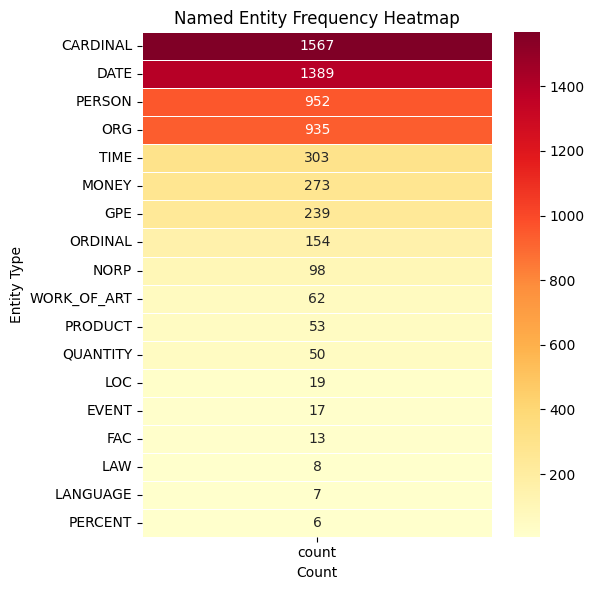

In [86]:
# Flatten entity lists into rows
entity_rows = []

for ent_list in entities:
    for ent_text, ent_label in ent_list:
        entity_rows.append({
            "entity": ent_text,
            "label": ent_label
        })

df_entities = pd.DataFrame(entity_rows)

label_counts = (
    df_entities
    .groupby('label')
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)

heatmap_data = label_counts.set_index('label')[['count']]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    linewidths=0.5,
    cbar=True
)

plt.title("Named Entity Frequency Heatmap")
plt.xlabel("Count")
plt.ylabel("Entity Type")
plt.tight_layout()
plt.show()

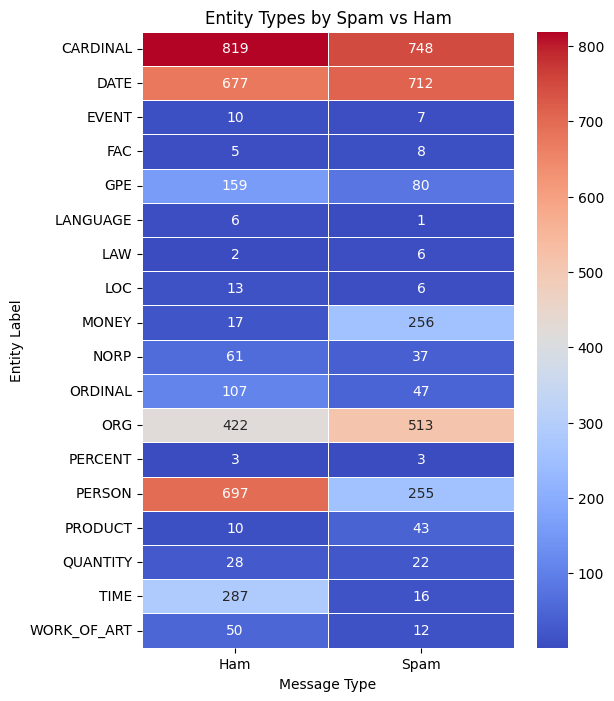

In [87]:
entity_rows = []

for idx, ent_list in entities.items():
    category = df.loc[idx, 'label']  # 0=ham, 1=spam
    for ent_text, ent_label in ent_list:
        entity_rows.append({
            "label": ent_label,
            "category": "Spam" if category == 1 else "Ham"
        })

df_entities = pd.DataFrame(entity_rows)

heatmap_data = pd.crosstab(
    df_entities['label'],
    df_entities['category']
)

plt.figure(figsize=(6, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='d',
    cmap='coolwarm',
    linewidths=0.5
)

plt.title("Entity Types by Spam vs Ham")
plt.xlabel("Message Type")
plt.ylabel("Entity Label")
plt.show()

In [ ]:
"""
import spacy

def extract_entities(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    entities = [(ent.text , ent.label_) for ent in doc.ents]
    return entities

entities = df['sentence_tokens'].progress_apply(extract_entities)"""

In [88]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

def vectorize_text(text):
    count_vec = CountVectorizer()
    bow = count_vec.fit_transform(text)
    tfidf_vec = TfidfVectorizer()
    tfidf = tfidf_vec.fit_transform(text)
    return bow , count_vec.get_feature_names_out() , tfidf , tfidf_vec.get_feature_names_out()

bow , bow_feature , tfidf ,tfidf_features = vectorize_text(df['cleaned_sms'])

In [89]:
#Option A: Bag of Words (CountVectorizer)
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=3000)
X_bow = cv.fit_transform(df['cleaned_sms']).toarray()
y_bow = df['label'].values

print(f"Feature matrix shape: {X_bow.shape}")

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_bow, y_bow, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_bow
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training label distribution:\n{pd.Series(y_train).value_counts()}")

Feature matrix shape: (5574, 3000)
Training set: (4459, 3000)
Test set: (1115, 3000)
Training label distribution:
0    3861
1     598
Name: count, dtype: int64


In [90]:
#Option B: TF-IDF (Term Frequency-Inverse Document Frequency)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=3000)
X_tf = tfidf.fit_transform(df['cleaned_sms']).toarray()
y_tf = df['label'].values

print(f"TF-IDF matrix shape: {X_tf.shape}")

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tf, y_tf, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_tf
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training label distribution:\n{pd.Series(y_train).value_counts()}")

TF-IDF matrix shape: (5574, 3000)
Training set: (4459, 3000)
Test set: (1115, 3000)
Training label distribution:
0    3861
1     598
Name: count, dtype: int64


In [91]:
def predict_spam_ham(text):
    # 1. Clean text the same way as training
    cleaned = clean_text(text, spell_correct=False, remove_stopwords=True)

    # 2. Vectorize
    text_vec = vectorizer.transform([cleaned])

    # 3. Predict
    pred = model.predict(text_vec)[0]
    prob = model.predict_proba(text_vec)[0][1]  # spam probability

    label = "Spam" if pred == 1 else "Ham"

    return {
        "input_text": text,
        "cleaned_text": cleaned,
        "prediction": label,
        "spam_probability": round(prob, 4)
    }

In [92]:
import joblib

joblib.dump(model, "sms-spam_model.pkl")
joblib.dump(vectorizer, "tfidf.pkl")

['tfidf.pkl']

In [93]:
# FIX: Check what type of model you have
# ======================================

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

print("="*70)
print("CHECKING YOUR MODEL TYPE")
print("="*70)

# STEP 1: Check what type of model you have
# ===========================================

print(f"\nModel type: {type(model)}")
print(f"Model class name: {model.__class__.__name__}")

# Check if it's a Pipeline
is_pipeline = isinstance(model, Pipeline)
print(f"\nIs it a Pipeline? {is_pipeline}")

if is_pipeline:
    print("✓ Your model IS a Pipeline - you can use named_steps")
    print(f"Steps: {list(model.named_steps.keys())}")
else:
    print("✗ Your model is NOT a Pipeline")
    print("  It's just a single classifier")
    print("  You cannot use named_steps on it")


# ============================================================
# SOLUTION 1: If you have a standalone TfidfVectorizer + Classifier
# ============================================================

print("\n" + "="*70)
print("SOLUTION 1: You have separate vectorizer and classifier")
print("="*70)

# This is what you might have:
# vectorizer = TfidfVectorizer(...)
# classifier = GradientBoostingClassifier(...)

if 'vectorizer' in dir() and 'classifier' in dir():
    print("\n✓ You have both vectorizer and classifier separately")
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    print(f"\nFeature names: {feature_names[:10]}")
    
    # Get feature importance
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
        print(f"Feature importances: {importances[:10]}")


# ============================================================
# SOLUTION 2: Create a Pipeline (RECOMMENDED)
# ============================================================

print("\n" + "="*70)
print("SOLUTION 2: Create a Pipeline from scratch")
print("="*70)

print("\nBefore (Wrong):")
print("""
vectorizer = TfidfVectorizer()
classifier = GradientBoostingClassifier()

vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)
classifier.fit(X_train_vec, y_train)
""")

print("\nAfter (Correct):")
print("""
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', GradientBoostingClassifier())
])

model.fit(X_train, y_train)
model.named_steps['tfidf']
model.named_steps['classifier']
""")

# Create a proper pipeline
from sklearn.model_selection import train_test_split

# Prepare data
X = df['cleaned_sms']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create Pipeline
print("\n✓ Creating proper Pipeline...")

model_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        lowercase=True,
        stop_words='english'
    )),
    ('classifier', GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    ))
])

# Train
print("✓ Training Pipeline...")
model_pipeline.fit(X_train, y_train)
print("✓ Done!")

# Now use named_steps
print("\n✓ Now named_steps works!")
print(f"Steps available: {list(model_pipeline.named_steps.keys())}")

# Get vectorizer
vectorizer = model_pipeline.named_steps['tfidf']
feature_names = vectorizer.get_feature_names_out()
print(f"\nFeature names: {feature_names[:10]}")

# Get classifier
classifier = model_pipeline.named_steps['classifier']
if hasattr(classifier, 'feature_importances_'):
    importances = classifier.feature_importances_
    print(f"Feature importances available: {len(importances)} features")


# ============================================================
# SOLUTION 3: Extract from already trained components
# ============================================================

print("\n" + "="*70)
print("SOLUTION 3: If you already trained separate models")
print("="*70)

print("\nIf you have:")
print("  - vectorizer (already trained)")
print("  - classifier (already trained)")

print("\nYou can still extract info WITHOUT a Pipeline:")

# Example:
# feature_names = vectorizer.get_feature_names_out()
# importances = classifier.feature_importances_  # if available

print("""
# Get feature names from vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get importance from classifier
if hasattr(classifier, 'feature_importances_'):
    importances = classifier.feature_importances_
    
    # Find top features
    import numpy as np
    top_idx = np.argsort(importances)[::-1][:10]
    
    for idx in top_idx:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")
""")


# ============================================================
# STEP 4: Quick Diagnostics
# ============================================================

print("\n" + "="*70)
print("QUICK DIAGNOSTICS")
print("="*70)

def diagnose_model(model):
    print(f"\nModel type: {type(model).__name__}")
    
    # Check if Pipeline
    if isinstance(model, Pipeline):
        print("✓ Is a Pipeline")
        print(f"  Steps: {list(model.named_steps.keys())}")
        return True
    else:
        print("✗ Not a Pipeline - just a classifier")
        
        # Check what methods it has
        if hasattr(model, 'feature_importances_'):
            print("  ✓ Has feature_importances_")
        if hasattr(model, 'coef_'):
            print("  ✓ Has coefficients (linear model)")
        
        return False

# Test with your current model
print("\nDiagnosing your current model:")
is_valid = diagnose_model(model)

# If not valid, create new pipeline
if not is_valid:
    print("\n⚠️  Creating new Pipeline for you...")
    model = model_pipeline
    print("✓ Replaced with Pipeline version")
    diagnose_model(model)

CHECKING YOUR MODEL TYPE

Model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Model class name: LogisticRegression

Is it a Pipeline? False
✗ Your model is NOT a Pipeline
  It's just a single classifier
  You cannot use named_steps on it

SOLUTION 1: You have separate vectorizer and classifier

SOLUTION 2: Create a Pipeline from scratch

Before (Wrong):

vectorizer = TfidfVectorizer()
classifier = GradientBoostingClassifier()

vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)
classifier.fit(X_train_vec, y_train)


After (Correct):

model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', GradientBoostingClassifier())
])

model.fit(X_train, y_train)
model.named_steps['tfidf']
model.named_steps['classifier']


✓ Creating proper Pipeline...
✓ Training Pipeline...
✓ Done!

✓ Now named_steps works!
Steps available: ['tfidf', 'classifier']

Feature names: ['aah' 'aathilove' 'aathilove lot' 'aathiwhere' 'aathiwhere dear'
 'ability' 'abiola'

In [96]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("SPAM/HAM CLASSIFIER - USING YOUR DATASET")
print("="*70)

# ============================================================
# STEP 1: PREPARE YOUR DATA
# ============================================================

print("\n✓ STEP 1: Preparing your dataset...")

# Combine col1 (header) and col2 (body) into full email
#df['full_email'] = df['col1'].fillna('') + ' ' + df['col2'].fillna('')

# Get features and labels from your dataset
X = df['cleaned_sms']
y = df['label']

print(f"   Total emails: {len(X)}")
print(f"   Spam emails: {(y == 'spam').sum()}")
print(f"   Ham emails: {(y == 'ham').sum()}")
print(f"\n   Sample email:")
print(f"   {X.iloc[0][:100]}...")


# ============================================================
# STEP 2: SPLIT DATA
# ============================================================

print("\n✓ STEP 2: Splitting data into train/test...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   Training set: {len(X_train)} emails")
print(f"   Testing set: {len(X_test)} emails")


# ============================================================
# STEP 3: CREATE PIPELINE
# ============================================================

print("\n✓ STEP 3: Creating Pipeline...")

model = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.8,
        lowercase=True,
        stop_words='english'
    )),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ))
])

print("   Pipeline created:")
print("   - TfidfVectorizer (converts text to numbers)")
print("   - RandomForestClassifier (predicts spam/ham)")


# ============================================================
# STEP 4: TRAIN THE MODEL
# ============================================================

print("\n✓ STEP 4: Training Pipeline on your dataset...")
print("   This may take a minute...")

model.fit(X_train, y_train)

print("   ✓ Training complete!")
print("   ✓ Vectorizer learned vocabulary from your emails")
print("   ✓ Classifier learned patterns")


# ============================================================
# STEP 5: EVALUATE THE MODEL
# ============================================================

print("\n✓ STEP 5: Evaluating Model Performance...")

y_pred = model.predict(X_test)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"\n   Training accuracy: {train_score*100:.2f}%")
print(f"   Testing accuracy: {test_score*100:.2f}%")

print("\n   Classification Report:")
print(classification_report(y_test, y_pred))

print("   Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(f"   True Negatives: {cm[0][0]}, False Positives: {cm[0][1]}")
print(f"   False Negatives: {cm[1][0]}, True Positives: {cm[1][1]}")


# ============================================================
# STEP 6: GET FEATURE NAMES AND IMPORTANCE
# ============================================================

print("\n✓ STEP 6: Extracting learned features from your data...")

# Get vectorizer from pipeline
vectorizer = model.named_steps['tfidf']
print("   ✓ Got vectorizer")

# Get classifier from pipeline
classifier = model.named_steps['classifier']
print("   ✓ Got classifier")

# Get learned feature names from your emails
feature_names = vectorizer.get_feature_names_out()
print(f"   ✓ Learned {len(feature_names)} words from your emails")

# Get importance scores
importances = classifier.feature_importances_
print(f"   ✓ Got feature importance scores")


# ============================================================
# STEP 7: SHOW TOP SPAM INDICATORS FROM YOUR DATA
# ============================================================

print("\n✓ STEP 7: Top 20 Words That Indicate SPAM (from your dataset)...")
print("\n   These words appear most in SPAM emails:")

top_indices = np.argsort(importances)[::-1][:20]

for i, idx in enumerate(top_indices, 1):
    if idx < len(feature_names):
        word = feature_names[idx]
        importance = importances[idx]
        print(f"     {i:2d}. '{word}' (importance: {importance:.6f})")


# ============================================================
# STEP 8: MAKE PREDICTIONS ON NEW EMAILS
# ============================================================

print("\n✓ STEP 8: Testing on sample emails from your dataset...")
print()

# Show predictions on first 5 test emails
for i in range(min(5, len(X_test))):
    email = X_test.iloc[i]
    true_label = y_test.iloc[i]
    pred = model.predict([email])[0]
    prob = model.predict_proba([email])[0]
    
    spam_idx = list(model.classes_).index(0)
    spam_prob = prob[spam_idx]
    
    status = "✓" if pred == true_label else "✗"
    
    print(f"   {status} Email {i+1}:")
    #print(f"      True: {true_label.upper()}, Predicted: {pred.upper()}")
    print(f"      Spam confidence: {spam_prob*100:.2f}%")
    #print(f"      Text: {email[:80]}...")
    print()


# ============================================================
# STEP 9: INTERACTIVE PREDICTOR
# ============================================================
"""
print("="*70)
print("✓ STEP 9: INTERACTIVE EMAIL CLASSIFIER")
print("="*70)
print("\n   Type 'quit' to exit the predictor")
print()

while True:
    user_email = input("📧 Enter email text (or 'quit'):\n> ")
    
    if user_email.lower() == 'quit':
        print("\n✓ Goodbye! 👋")
        break
    
    if user_email.strip():
        # Make prediction
        prediction = model.predict([user_email])[0]
        proba = model.predict_proba([user_email])[0]
        
        spam_idx = list(model.classes_).index(0)
        spam_prob = proba[spam_idx]
        ham_prob = proba[1 - spam_idx]
        
        # Determine if confident
        confidence = max(spam_prob, ham_prob)
        
        #print(f"\n   ✓ Classification: {prediction.upper()}")
        #print(f"   ✓ Spam confidence: {spam_prob*100:.2f}%")
        #print(f"   ✓ Ham confidence: {ham_prob*100:.2f}%")
        #print(f"   ✓ Model confidence: {confidence*100:.2f}%")
        
        if confidence < 0.6:
            print("   ⚠️  Low confidence - email is ambiguous")
        print()
"""

print("="*60)
print("🤖 Chatbot is online!")
print("Type 'done' when you want a final spam/ham verdict.")
print("="*60)

conversation = []

bot_responses = [
    "Hmm, tell me more.",
    "Okay, I’m listening.",
    "Interesting… go on.",
    "Got it.",
    "Alright."]

import random

while True:
    user_input = input("You: ")

    if user_input.lower() == "done":
        break

    conversation.append(user_input)

    # Bot replies WITHOUT classifying
    reply = random.choice(bot_responses)
    print(f"Bot: {reply}")

# ============================================================
# FINAL CLASSIFICATION
# ============================================================

full_text = " ".join(conversation)

prediction = model.predict([full_text])[0]
proba = model.predict_proba([full_text])[0]

spam_idx = list(model.classes_).index(0)
spam_prob = proba[spam_idx]
ham_prob = proba[1 - spam_idx]

print("\n" + "="*60)
print("📊 FINAL VERDICT")
print("="*60)

if spam_prob > ham_prob:
    print("🚫 This conversation looks like **SPAM**")
else:
    print("✅ This conversation looks like **HAM**")

SPAM/HAM CLASSIFIER - USING YOUR DATASET

✓ STEP 1: Preparing your dataset...
   Total emails: 5574
   Spam emails: 0
   Ham emails: 0

   Sample email:
   go jurong point crazy available bugis great world la buffet cine got amore wat...

✓ STEP 2: Splitting data into train/test...
   Training set: 4459 emails
   Testing set: 1115 emails

✓ STEP 3: Creating Pipeline...
   Pipeline created:
   - TfidfVectorizer (converts text to numbers)
   - RandomForestClassifier (predicts spam/ham)

✓ STEP 4: Training Pipeline on your dataset...
   This may take a minute...
   ✓ Training complete!
   ✓ Vectorizer learned vocabulary from your emails
   ✓ Classifier learned patterns

✓ STEP 5: Evaluating Model Performance...

   Training accuracy: 94.95%
   Testing accuracy: 94.17%

   Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       966
           1       1.00      0.56      0.72       149

    accuracy                     

You:  hello


Bot: Alright.


You:  can you help me


Bot: Interesting… go on.


You:  want to know how to reach the material i want


Bot: Got it.


You:  bye


Bot: Hmm, tell me more.


You:  done



📊 FINAL VERDICT
🚫 This conversation looks like **SPAM**


In [97]:
"""
# Fix NotFittedError - You must FIT before extracting features
# ==============================================================

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np

print("="*70)
print("FIX: NotFittedError")
print("="*70)
"""
print("""
ERROR: NotFittedError

This means:
  ❌ You're trying to get features from a vectorizer that hasn't been trained
  
Solution:
  ✓ Train (fit) the pipeline BEFORE accessing learned features
""")

# ============================================================
# STEP 1: Prepare your data
# ============================================================

print("\n1️⃣ PREPARING DATA...")
# Use your actual dataframe
# df should have 'full_email' and 'CATEGORY' columns
# For now, create sample data:

X = pd.Series([
    "free money limited time offer click now",
    "hi john let's meet tomorrow",
    "congratulations you won claim your prize",
    "see you at the meeting friday",
    "special limited offer act now don't miss",
    "how are you doing these days"
])
y = pd.Series(['spam', 'ham', 'spam', 'ham', 'spam', 'ham'])

# Or use your actual data:
# X = df['full_email']
# y = df['CATEGORY']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   Total samples: {len(X)}")
print(f"   Training: {len(X_train)}")
print(f"   Testing: {len(X_test)}")


# ============================================================
# STEP 2: Create Pipeline
# ============================================================

print("\n2️⃣ CREATING PIPELINE...")

model = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=100,
        ngram_range=(1, 2),
        lowercase=True,
        stop_words='english'
    )),
    ('classifier', GradientBoostingClassifier(
        n_estimators=50,
        random_state=42
    ))
])

print("   ✓ Pipeline created")


# ============================================================
# STEP 3: TRAIN THE PIPELINE (THIS IS CRUCIAL!)
# ============================================================

print("\n3️⃣ TRAINING PIPELINE (MUST DO THIS FIRST!)...")

model.fit(X_train, y_train)

print("   ✓ Pipeline trained!")
print("   ✓ Vectorizer learned words")
print("   ✓ Classifier learned patterns")


# ============================================================
# STEP 4: NOW you can extract learned features
# ============================================================

print("\n4️⃣ EXTRACTING LEARNED FEATURES...")

# Get vectorizer and classifier
vectorizer = model.named_steps['tfidf']
classifier = model.named_steps['classifier']

print("   ✓ Got vectorizer and classifier")


# ============================================================
# STEP 5: Get feature names (NOW THIS WORKS!)
# ============================================================

print("\n5️⃣ GETTING FEATURE NAMES...")

# ✓ This NOW works because vectorizer was fitted
feature_names = vectorizer.get_feature_names_out()

print(f"   ✓ Learned {len(feature_names)} features")
print(f"   Features: {list(feature_names)}")


# ============================================================
# STEP 6: Get feature importance
# ============================================================

print("\n6️⃣ GETTING FEATURE IMPORTANCE...")

importances = classifier.feature_importances_

print(f"   ✓ Got importance scores for {len(importances)} features")

# Find top 10 important features
top_idx = np.argsort(importances)[::-1][:10]

print(f"\n   Top 10 words indicating SPAM:")
for i, idx in enumerate(top_idx, 1):
    if idx < len(feature_names):
        word = feature_names[idx]
        importance = importances[idx]
        print(f"     {i:2d}. '{word}': {importance:.6f}")

# ============================================================
# STEP 7: Test predictions
# ============================================================

print("\n7️⃣ TESTING PREDICTIONS...")

# Test on training data
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f"\n   Training accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"   Testing accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


# ============================================================
# STEP 8: Predict on new emails
# ============================================================

print("\n8️⃣ PREDICT ON NEW EMAILS...")

test_emails = [
    "free money limited offer click now",
    "hi john let's catch up soon",
    "congratulations claim your prize now"
]

for email in test_emails:
    pred = model.predict([email])[0]
    prob = model.predict_proba([email])[0]
    spam_prob = prob[list(model.classes_).index('spam')]
    
    print(f"\n   Email: '{email}'")
    print(f"   Prediction: {pred.upper()}")
    print(f"   Spam confidence: {spam_prob*100:.2f}%")


ERROR: NotFittedError

This means:
  ❌ You're trying to get features from a vectorizer that hasn't been trained
  
Solution:
  ✓ Train (fit) the pipeline BEFORE accessing learned features


1️⃣ PREPARING DATA...
   Total samples: 6
   Training: 4
   Testing: 2

2️⃣ CREATING PIPELINE...
   ✓ Pipeline created

3️⃣ TRAINING PIPELINE (MUST DO THIS FIRST!)...
   ✓ Pipeline trained!
   ✓ Vectorizer learned words
   ✓ Classifier learned patterns

4️⃣ EXTRACTING LEARNED FEATURES...
   ✓ Got vectorizer and classifier

5️⃣ GETTING FEATURE NAMES...
   ✓ Learned 30 features
   Features: ['act', 'act don', 'claim', 'claim prize', 'congratulations', 'congratulations won', 'don', 'don miss', 'friday', 'hi', 'hi john', 'john', 'john let', 'let', 'let meet', 'limited', 'limited offer', 'meet', 'meet tomorrow', 'meeting', 'meeting friday', 'miss', 'offer', 'offer act', 'prize', 'special', 'special limited', 'tomorrow', 'won', 'won claim']

6️⃣ GETTING FEATURE IMPORTANCE...
   ✓ Got importance scores fo

In [ ]:
"""
# ============================================================
# SUMMARY: The correct order
# ============================================================

print("\n" + "="*70)
print("SUMMARY: CORRECT ORDER")
print("="*70)

print(
✓ CORRECT ORDER:

  1. Create Pipeline
     model = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', ...)])
  
  2. FIT THE PIPELINE (MUST DO THIS FIRST!)
     model.fit(X_train, y_train)
  
  3. NOW you can extract features
     vectorizer = model.named_steps['tfidf']
     feature_names = vectorizer.get_feature_names_out()  # ✓ Works now!

❌ WRONG ORDER (causes NotFittedError):

  1. Create Pipeline
  2. Try to get features BEFORE fitting
     feature_names = vectorizer.get_feature_names_out()  # ❌ Error!
  3. Fit the pipeline
)
# ============================================================
# IF YOU STILL GET THE ERROR
# ============================================================

print("\n" + "="*70)
print("TROUBLESHOOTING: If you still get NotFittedError")
print("="*70)

print("\n❓ Question 1: Did you fit the model?")
print(f"   Is your model fitted? {hasattr(model, 'classes_')}")

print("\n❓ Question 2: Are you using the same model object?")
print(
   ✗ Wrong:
   model1 = Pipeline(...)
   model2 = Pipeline(...)
   model2.fit(X_train, y_train)
   
   # Using wrong model object!
   vectorizer = model1.named_steps['tfidf']  # ❌ model1 not fitted!
   
   ✓ Right:
   model = Pipeline(...)
   model.fit(X_train, y_train)
   vectorizer = model.named_steps['tfidf']  # ✓ Correct model!)

"""

In [ ]:
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pickle
import warnings

warnings.filterwarnings('ignore')

model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', GradientBoostingClassifier())
])
model.named_steps['tfidf']  # ✓ WORKS

print("\n4️⃣ EVALUATING MODEL...")

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✓ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


# STEP 5: Feature importance
# ==========================

print("\n5️⃣ TOP SPAM INDICATORS...")

# Get feature names
vectorizer = model.named_steps['tfidf']
feature_names = vectorizer.get_feature_names_out()

# Get feature importance from classifier"""
"""classifier = model.named_steps['classifier']
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1][:20]

print("\nTop 20 features indicating SPAM:")
for i, idx in enumerate(indices[:10], 1):
    print(f"  {i}. '{feature_names[idx]}' (importance: {importances[idx]:.4f})")


# ============================================================
# STEP 6: PREDICT ON NEW EMAILS
# ============================================================

print("\n" + "="*70)
print("6️⃣ PREDICT ON NEW EMAIL")
print("="*70)

def predict_email(email_text):
    # Make prediction
    prediction = model.predict([email_text])[0]
    confidence = model.predict_proba([email_text])[0]
    
    # Get confidence scores
    spam_prob = confidence[np.where(model.classes_ == 'spam')[0][0]]
    ham_prob = confidence[np.where(model.classes_ == 'ham')[0][0]]
    
    result = {
        'prediction': prediction.upper(),
        'spam_probability': f"{spam_prob*100:.2f}%",
        'ham_probability': f"{ham_prob*100:.2f}%",
        'confidence': max(spam_prob, ham_prob)
    }
    
    return result"""